<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [254]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import importlib
import matplotlib.pyplot as plt

import plotting_functions as mp
import analytical_functions as af

importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [255]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [256]:
fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot',
            'TR.CommonName', 'TR.NAICSSector']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

### Getting different groups of stocks based on their leverage ratio

We will use, at this stage, as a proxy of the value of the assets the sum of the market capitalization of a given firmi and the firm's total debt

In [257]:
random = False
if not random:

    rics_list = ['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N', 'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 
                'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N', 'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ']
    
else:

    rics_list = ['0#.SPX']

In [258]:
#This will get all the stocks in the S&P 500 data_cross for the specified fields
data_cross, err = ek.get_data(instruments= rics_list, fields = fields)
data_cross.head()

number = data_cross.shape[0]

#Excluding financial sector
data_cross = data_cross[data_cross['NAICS Sector Name'] != 'Finance and Insurance']
post_number = data_cross.shape[0]

print(f'Removed {number - post_number} companies, for a total of {data_cross.shape[0]} companies')

Removed 0 companies, for a total of 20 companies


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [259]:
data_cross['Equity Value'] = data_cross['Close Price'] * data_cross['Shares used to calculate Diluted EPS - Total']

data_cross['Asset Value'] = data_cross['Equity Value'] + data_cross['Debt - Total']

data_cross['Leverage Ratio'] = data_cross['Debt - Total'] / data_cross['Asset Value']

data_cross = data_cross.sort_values(by = 'Leverage Ratio', ascending= False)

data_cross = data_cross.dropna(subset=['Leverage Ratio'])

print(data_cross.head())

  Instrument                  Date  Close Price  \
4      KMX.N  2025-01-03T00:00:00Z        80.07   
1    VTRS.OQ  2025-01-03T00:00:00Z        12.28   
3      EIX.N  2025-01-03T00:00:00Z         79.8   
2    EVRG.OQ  2025-01-03T00:00:00Z        61.55   
0     AEP.OQ  2025-01-03T00:00:00Z        92.05   

   Shares used to calculate Diluted EPS - Total  Market Capitalization  \
4                                     158707000          12451343181.0   
1                                    1206900000         12990936920.85   
3                                     385000000     27421327292.369999   
2                                     230500000     11990452438.799999   
0                                     520206258     42711651075.379997   

   Debt - Total                  Company Common Name NAICS Sector Name  \
4   18976741000                           Carmax Inc      Retail Trade   
1   18131500000                          Viatris Inc     Manufacturing   
3   34090000000           

In [260]:
print(data_cross[['Company Common Name', 'Leverage Ratio']].head(100))

                    Company Common Name  Leverage Ratio
4                            Carmax Inc         0.59893
1                           Viatris Inc        0.550236
3                  Edison International        0.525975
2                            Evergy Inc         0.48201
0   American Electric Power Company Inc        0.474161
8                              AT&T Inc        0.454934
5               Consolidated Edison Inc        0.439749
7                           Southern Co        0.406858
6                   Delta Air Lines Inc        0.345812
9                             Amcor PLC        0.332563
12                             Fox Corp        0.233134
14                  Newmont Corporation        0.227447
11      Philip Morris International Inc        0.201802
13                    Brown-Forman Corp        0.151967
10                 Generac Holdings Inc        0.137753
15                           Dover Corp        0.115998
16              Zebra Technologies Corp        0

### Clustering the stocks based on their leverage ratio

In [261]:
# Cluster them

n_clusters = 4

if random:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score



    scaler = MinMaxScaler()
    data_cross['leverage_ratio_normalized'] = scaler.fit_transform(data_cross[['Leverage Ratio']])

    silhouette_scores = []
    for k in range(2, 11):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
        silhouette_scores.append(silhouette_score(data_cross[['leverage_ratio_normalized']], labels))

    # Plot silhouette scores
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data_cross[['leverage_ratio_normalized']])
    # Add cluster labels to the data_crossFrame
    data_cross['cluster'] = labels
    cluster_means = data_cross.groupby('cluster')['Leverage Ratio'].mean()

    ranked_clusters = cluster_means.sort_values(ascending=False).rank(ascending=False).astype(int)

    # Step 3: Map ranked cluster numbers back to the data_crossFrame
    ranked_mapping = {cluster: rank for cluster, rank in zip(cluster_means.sort_values(ascending=False).index, ranked_clusters)}
    data_cross['ranked_cluster'] = data_cross['cluster'].map(ranked_mapping)

    print(data_cross[['Leverage Ratio', 'cluster', 'ranked_cluster']])

    print('\nThe companies for each cluster are:')
    data_cross['ranked_cluster'].value_counts()

else: 

    data_cross['ranked_clusters'] = np.repeat(range(1, n_clusters + 1), len(data_cross) // n_clusters)

cluster_dict = {

    1 : 'High',
    2: 'Medium-high',
    3: 'Medium-low',
    4: 'Low'

}

In [262]:
if random:
    # Sample 5 companies from each cluster
    sampled_data = data_cross.groupby('ranked_cluster').apply(lambda x: x.sample(n=5, random_state=42))

    # Reset index to make it easier to work with
    sampled_data = sampled_data.reset_index(drop=True)

    print(sampled_data.sort_values(by = 'Leverage Ratio', ascending = False))

else:

    sampled_data = data_cross.sort_values(by = 'Leverage Ratio', ascending = False) 

In [263]:
random_sample = list(sampled_data['Instrument'])

print(random_sample)

['KMX.N', 'VTRS.OQ', 'EIX.N', 'EVRG.OQ', 'AEP.OQ', 'T.N', 'ED.N', 'SO.N', 'DAL.N', 'AMCR.N', 'FOXA.OQ', 'NEM.N', 'PM.N', 'BFb.N', 'GNRC.N', 'DOV.N', 'ZBRA.OQ', 'EOG.N', 'PANW.OQ', 'WST.N']


In [264]:
#Setting up the function


def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)

        data['Equity_Value'] = data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']

        
        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        #data['Rolling_Volatility'] = data['Log_Returns'].std() * np.sqrt(252)
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [265]:
removing_fields = ['TR.CommonName', 'TR.NAICSSector']

fields = [i for i in fields if i not in removing_fields]

#### Retrieving the data

In [266]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

print(data.head())

print('-'*100)

print(data.tail())

print('-'*100)
#Checks on single stocks
print(data.loc[rics_list[0]].head())

print('-')
print(data.loc[rics_list[1]].describe())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:10

                                      Close Price  \
Instrument Date                                     
AEP.OQ     2019-12-31 00:00:00+00:00        94.51   
           2020-01-02 00:00:00+00:00        93.46   
           2020-01-03 00:00:00+00:00        93.36   
           2020-01-06 00:00:00+00:00        93.67   
           2020-01-07 00:00:00+00:00        93.69   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AEP.OQ     2019-12-31 00:00:00+00:00                                   493758277.0   
           2020-01-02 00:00:00+00:00                                   493758277.0   
           2020-01-03 00:00:00+00:00                                   493758277.0   
           2020-01-06 00:00:00+00:00                                   493758277.0   
           2020-01-07 00:00:00+00:00                                   493758277.0   

                         

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [267]:
# Creating a RICS dictionary

index = data.index
unique_instruments = index.get_level_values('Instrument').unique()
print(unique_instruments)
print(len(unique_instruments))

unique_names = []

for ric in unique_instruments:

    row = data_cross[data_cross['Instrument'] == ric]
    
    name = row['Company Common Name'].iloc[0]
    unique_names.append(name)


print(unique_names)
#rics_dict = {key, value for key,value in unique_values}

rics_dict = {key:value for key,value in zip(unique_instruments, unique_names)}

Index(['AEP.OQ', 'VTRS.OQ', 'EVRG.OQ', 'EIX.N', 'KMX.N', 'ED.N', 'DAL.N',
       'SO.N', 'T.N', 'AMCR.N', 'GNRC.N', 'PM.N', 'FOXA.OQ', 'BFb.N', 'NEM.N',
       'DOV.N', 'ZBRA.OQ', 'WST.N', 'EOG.N', 'PANW.OQ'],
      dtype='string', name='Instrument')
20
['American Electric Power Company Inc', 'Viatris Inc', 'Evergy Inc', 'Edison International', 'Carmax Inc', 'Consolidated Edison Inc', 'Delta Air Lines Inc', 'Southern Co', 'AT&T Inc', 'Amcor PLC', 'Generac Holdings Inc', 'Philip Morris International Inc', 'Fox Corp', 'Brown-Forman Corp', 'Newmont Corporation', 'Dover Corp', 'Zebra Technologies Corp', 'West Pharmaceutical Services Inc', 'EOG Resources Inc', 'Palo Alto Networks Inc']


In [268]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

## Computing the value of the asset and its volatility

In [269]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

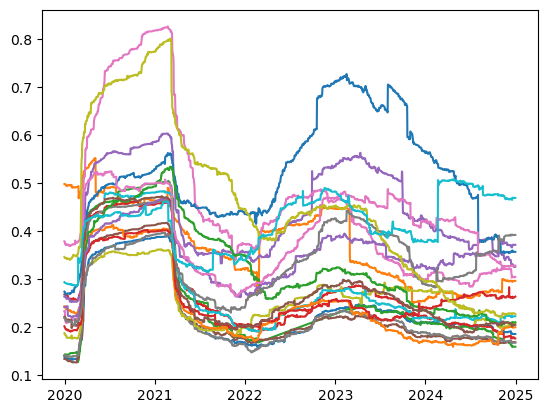

In [270]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [271]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [272]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Equity_Value                                    0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [273]:
#Computing the asset value and volatility at each point in time

#For 20 companies it should take approximately 1 min 
df_with_solutions = solve_for_all(data)
print(df_with_solutions.head())

                                      Close Price  \
Instrument Date                                     
AEP.OQ     2019-12-31 00:00:00+00:00        94.51   
           2020-01-02 00:00:00+00:00        93.46   
           2020-01-03 00:00:00+00:00        93.36   
           2020-01-06 00:00:00+00:00        93.67   
           2020-01-07 00:00:00+00:00        93.69   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AEP.OQ     2019-12-31 00:00:00+00:00                                   493758277.0   
           2020-01-02 00:00:00+00:00                                   493758277.0   
           2020-01-03 00:00:00+00:00                                   493758277.0   
           2020-01-06 00:00:00+00:00                                   493758277.0   
           2020-01-07 00:00:00+00:00                                   493758277.0   

                         

In [274]:
df_with_solutions.columns

Index(['Close Price', 'Shares used to calculate Diluted EPS - Total',
       'Market Capitalization', 'Debt - Total', 'RIC', 'Equity_Value',
       'Log_Returns', 'Rolling_Volatility', 'Total_value', 'A_solution',
       'sigma_A_solution'],
      dtype='object')

In [275]:
#Adding leverage ration

df_with_solutions['Leverage_Ratio'] = df_with_solutions['Debt - Total'] / df_with_solutions['A_solution']

## Computing the relevant quantities of the Merton's model

In [276]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    #M = 1_000_000

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    #mc_default_probability = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_sim = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_default_probability = mc_sim[2]
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    #credit_spread_2 = af.credit_spread_model_new(V, K, sigma, r, T, t)


    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        #'MC_Default_Probability': mc_default_probability,
        'Credit_Spread': credit_spread
        
    })
#'Credit_Spread_2': credit_spread_2

In [277]:
importlib.reload(af)

#Compute the equity value, debt value and probability of default for each company and at each date
#For 20 companies it should take approximately 40 sec
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

#Combine the quantities results with the original dataframe
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

#### Plotting the probability of default through time

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

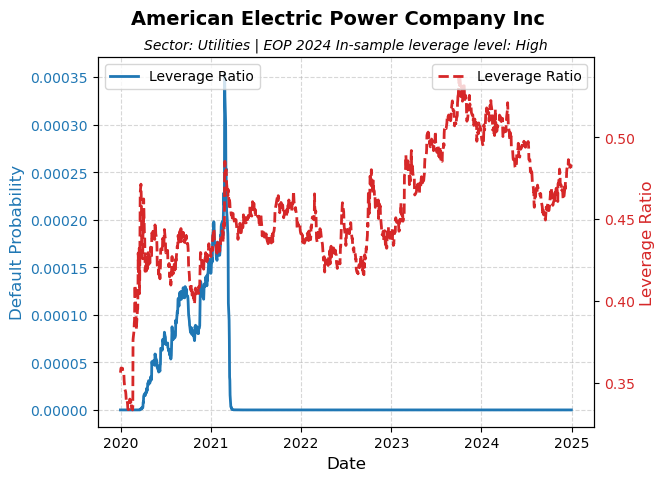

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

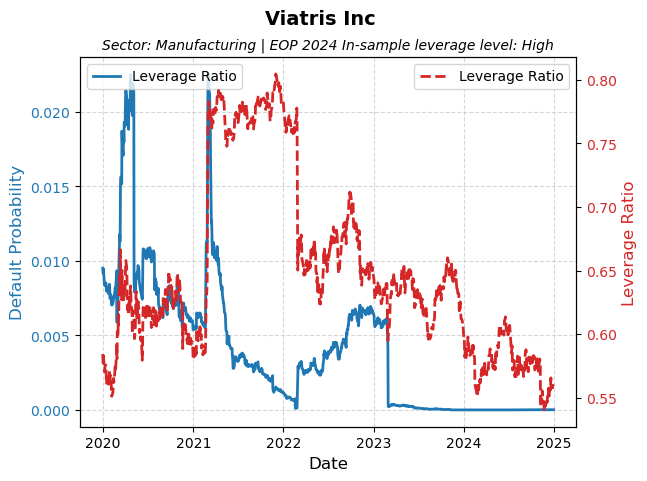

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

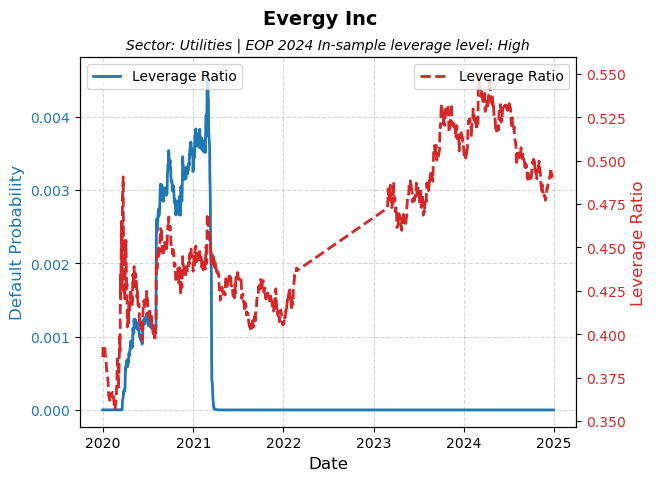

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

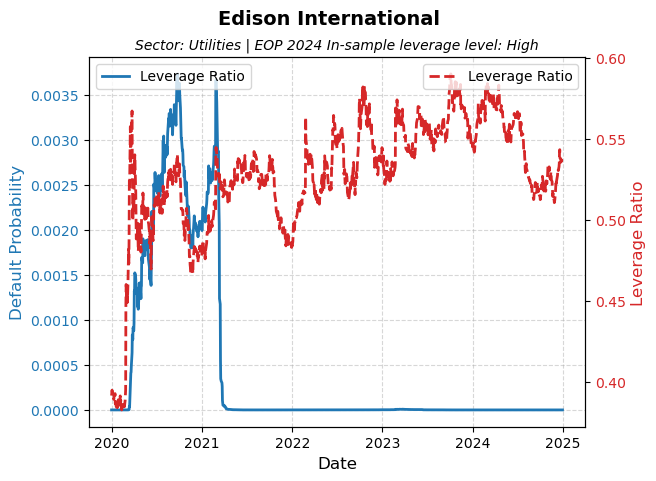

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

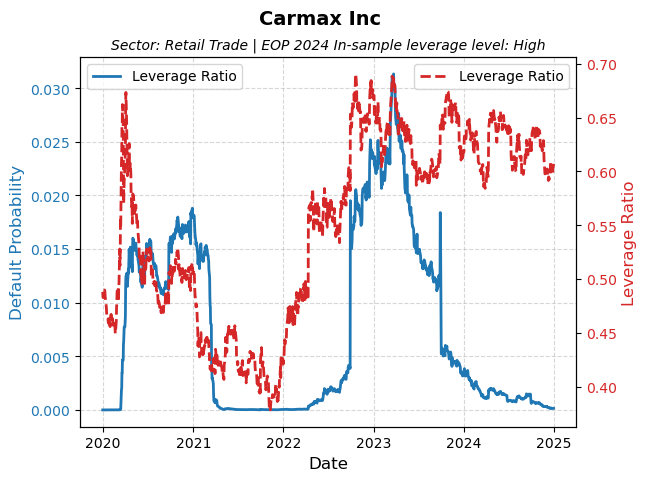

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

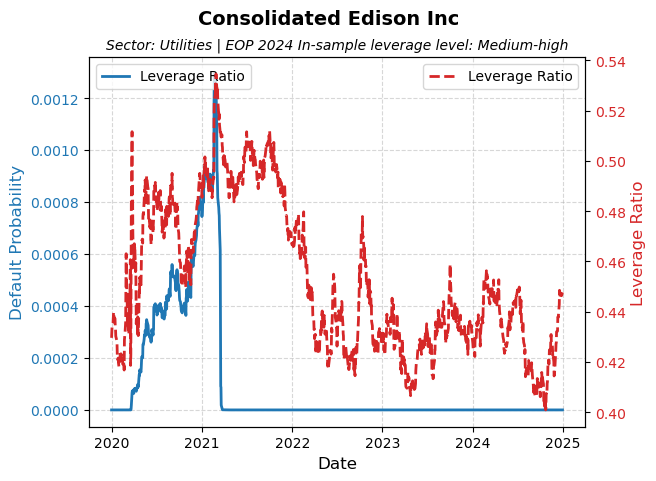

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

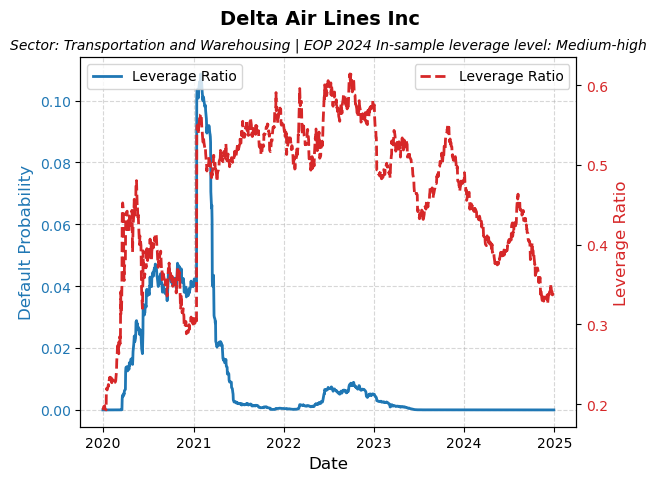

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

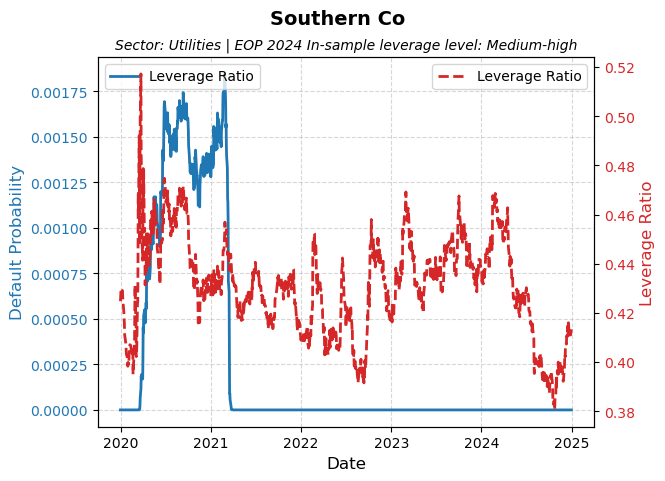

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

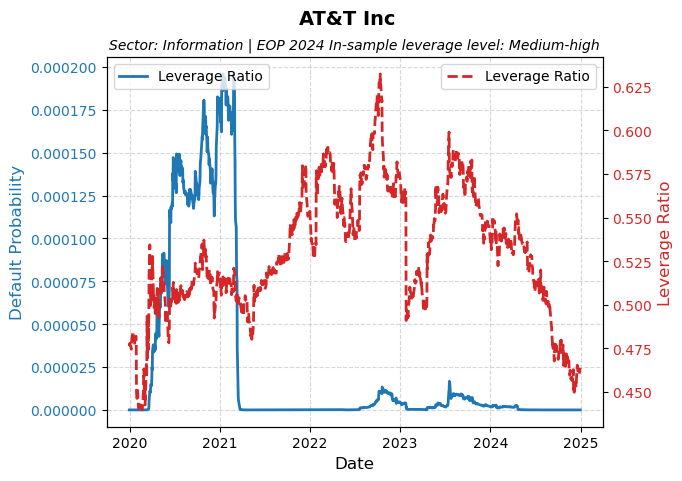

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

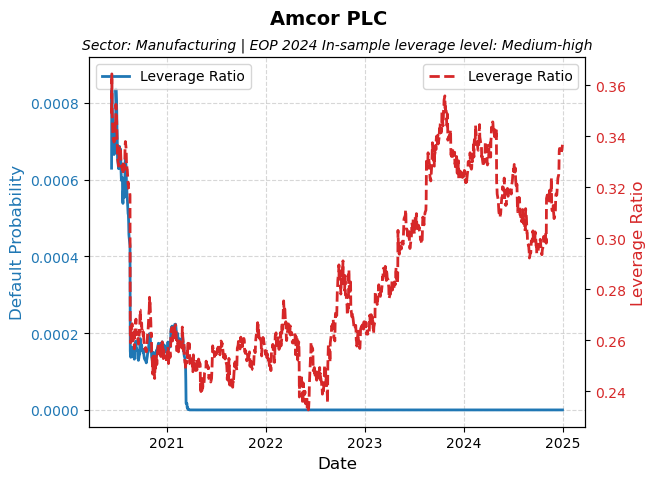

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

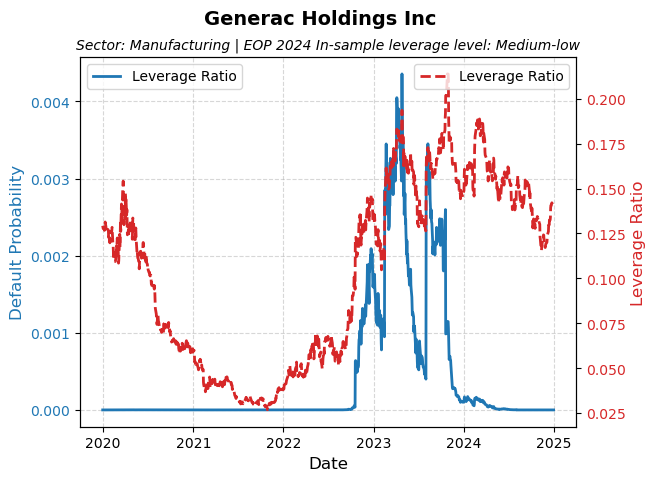

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

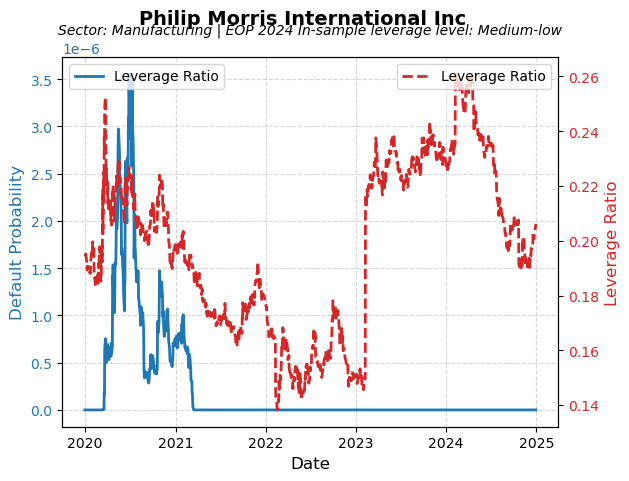

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

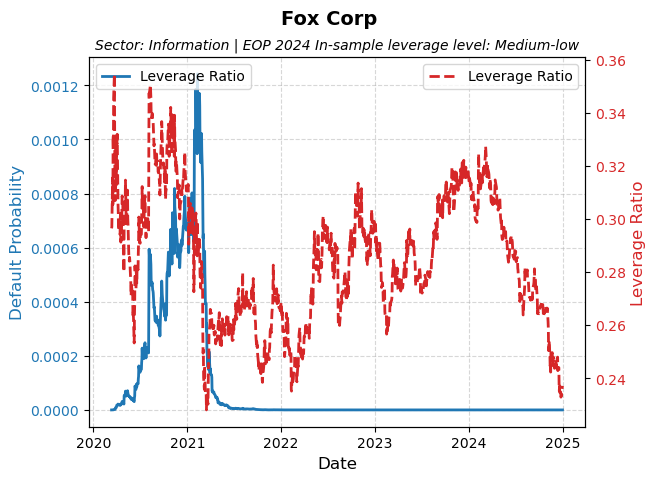

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

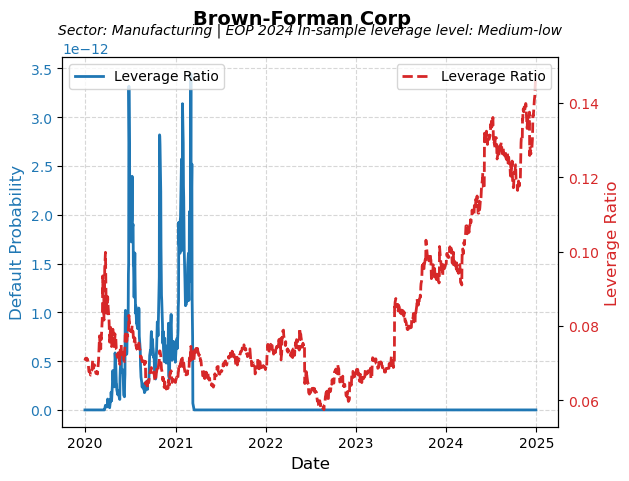

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

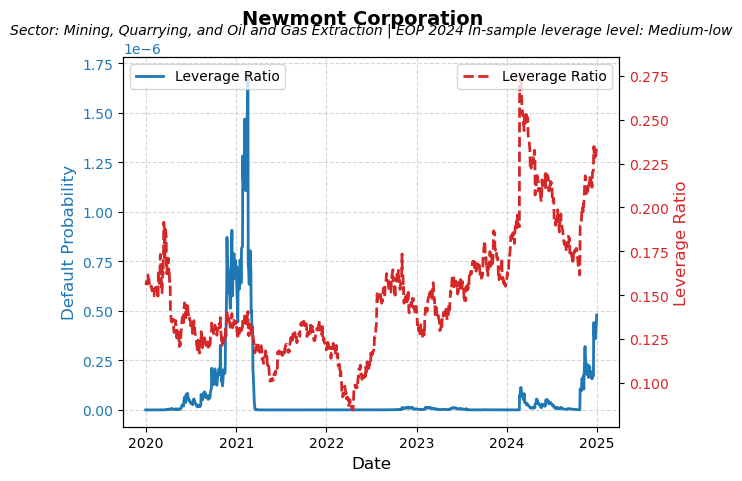

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

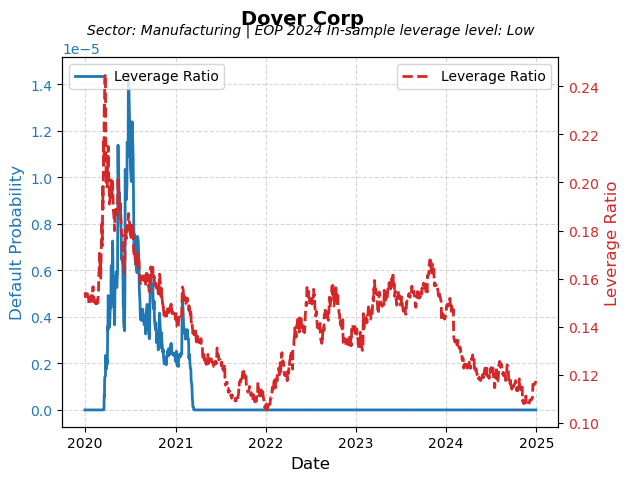

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

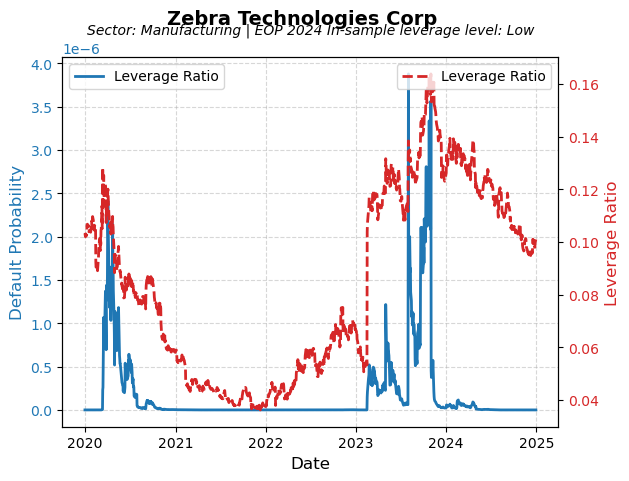

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

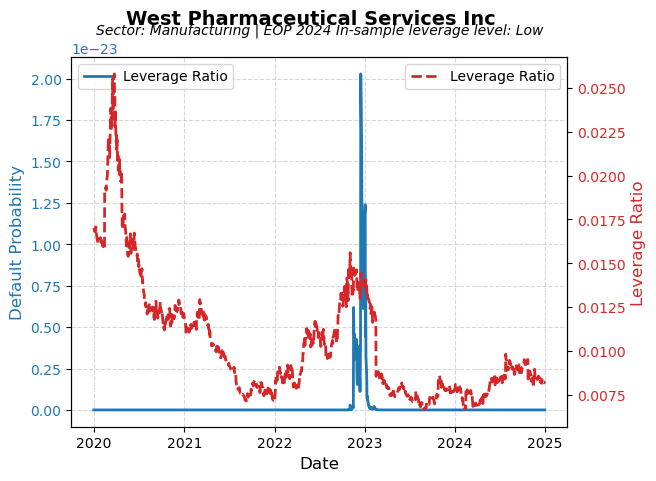

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

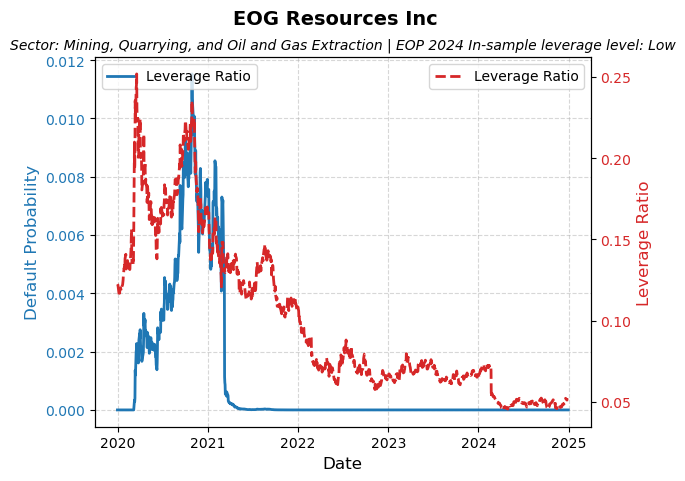

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\1099609040.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

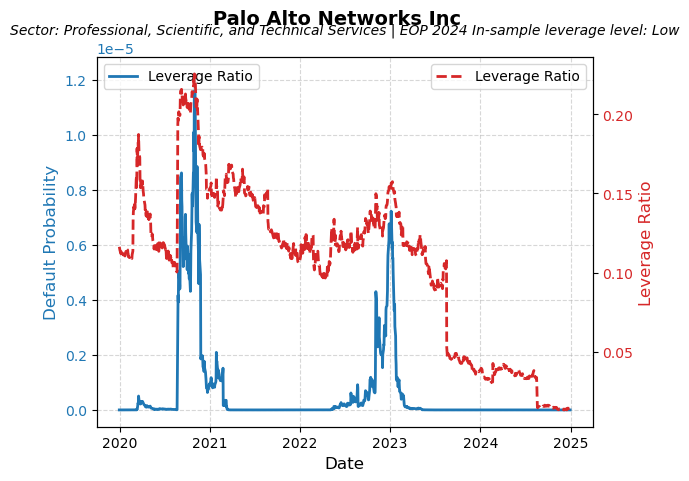

In [308]:
for ric in rics_list:
    row_cross = data_cross[data_cross['Instrument'] == ric]

    sector = row_cross['NAICS Sector Name'].iloc[0]
    cluster = row_cross['ranked_clusters'].iloc[0]

    plt.figure(figsize=(20, 6))  # Adjust figure size for better visualization

    # Extract data
    def_probab = df_final.loc[ric]['Default_Probability']
    leverage_ratio = df_final.loc[ric]['Leverage_Ratio']

    # Create the main axis
    fig, ax1 = plt.subplots()

    # Plot Default Probability on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(def_probab, color=color1, label='Leverage Ratio', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.plot(leverage_ratio, color=color2, label='Leverage Ratio', linewidth=2, linestyle='dashed')
    ax2.set_ylabel('Leverage Ratio', color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Add title and legend
    plt.suptitle(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')  # Move suptitle closer to the plot
    plt.title(f"Sector: {sector} | EOP 2024 In-sample leverage level: {cluster_dict[cluster]}", fontsize=10, fontstyle='italic')  # Move subtitle closer to suptitle

    fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()


In [279]:
data_cross.head()

Instrument                  Date  Close Price  \
4      KMX.N  2025-01-03T00:00:00Z        80.07   
1    VTRS.OQ  2025-01-03T00:00:00Z        12.28   
3      EIX.N  2025-01-03T00:00:00Z         79.8   
2    EVRG.OQ  2025-01-03T00:00:00Z        61.55   
0     AEP.OQ  2025-01-03T00:00:00Z        92.05   

   Shares used to calculate Diluted EPS - Total  Market Capitalization  \
4                                     158707000          12451343181.0   
1                                    1206900000         12990936920.85   
3                                     385000000     27421327292.369999   
2                                     230500000     11990452438.799999   
0                                     520206258     42711651075.379997   

   Debt - Total                  Company Common Name NAICS Sector Name  \
4   18976741000                           Carmax Inc      Retail Trade   
1   18131500000                          Viatris Inc     Manufacturing   
3   34090000000                 Edison International         Utilities   
2   13201800000                           Evergy Inc         Utilities   
0   43179000000  American Electric Power Company Inc         Utilities   

         Equity Value         Asset Value  Leverage Ratio  ranked_clusters  
4  12707669489.999998       31684410490.0         0.59893                1  
1       14820732000.0       32952232000.0        0.550236                1  
3       30723000000.0       64813000000.0        0.525975                1  
2       14187275000.0       27389075000.0         0.48201                1  
0  47884986048.900002  91063986048.899994        0.474161                1

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

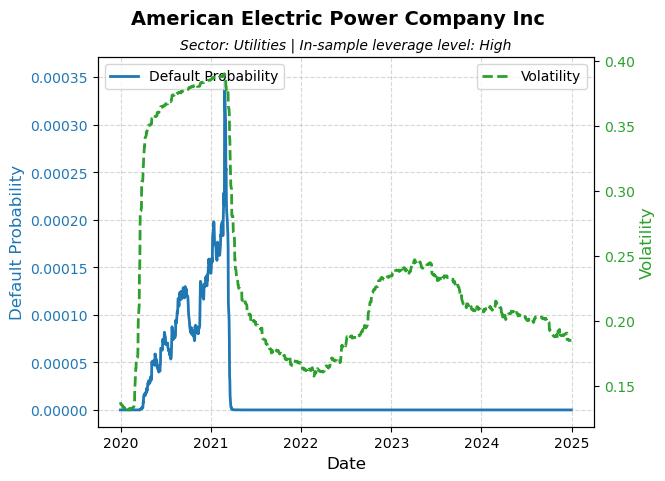

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

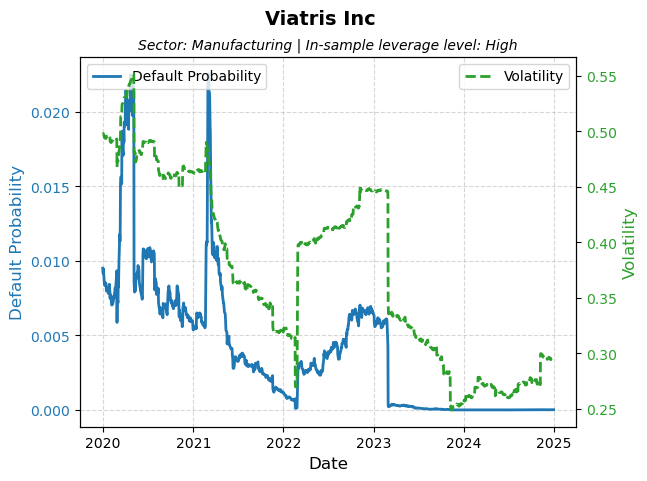

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

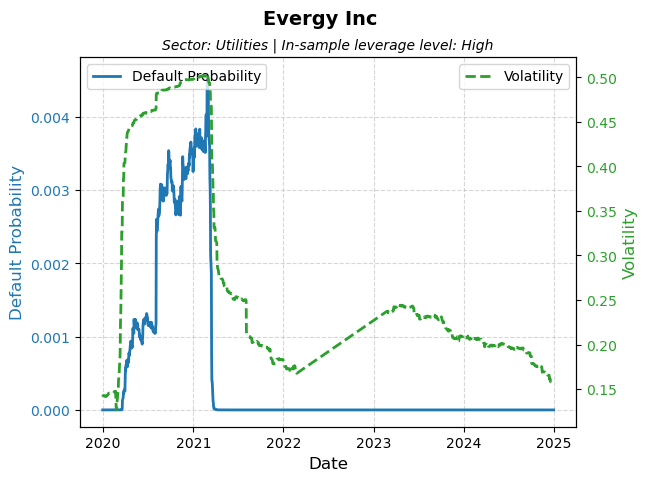

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

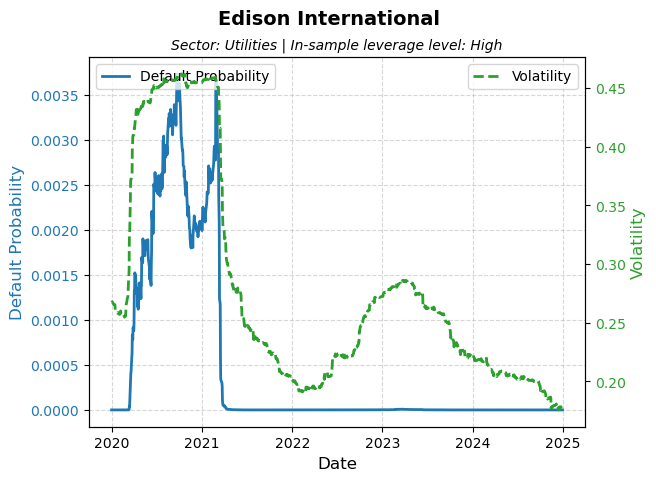

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

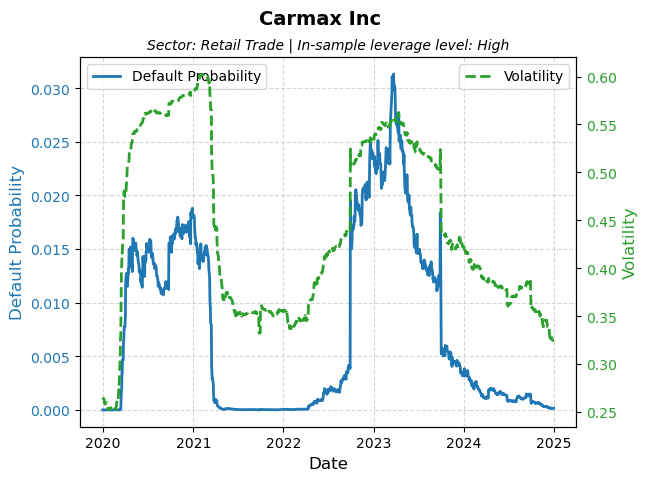

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

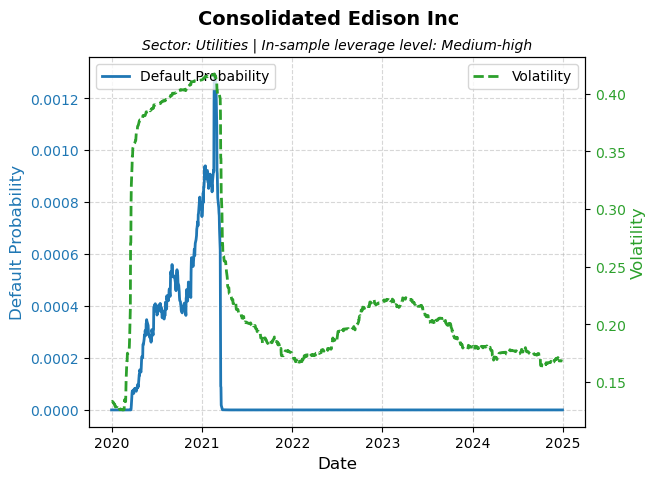

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

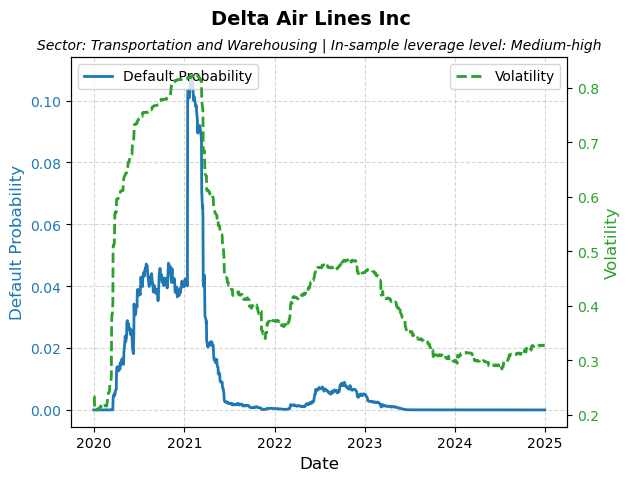

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

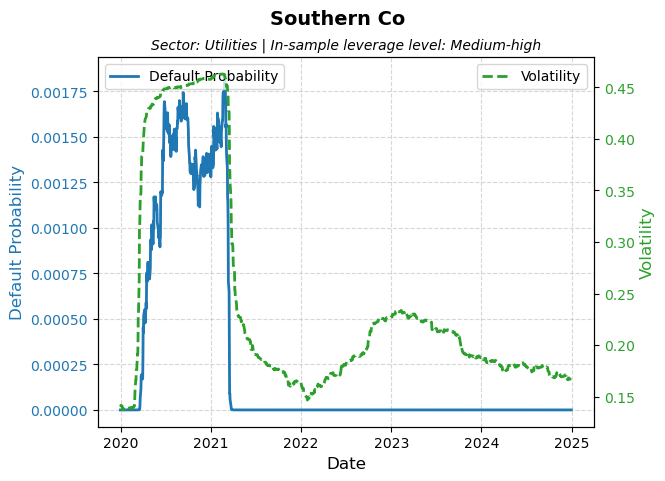

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

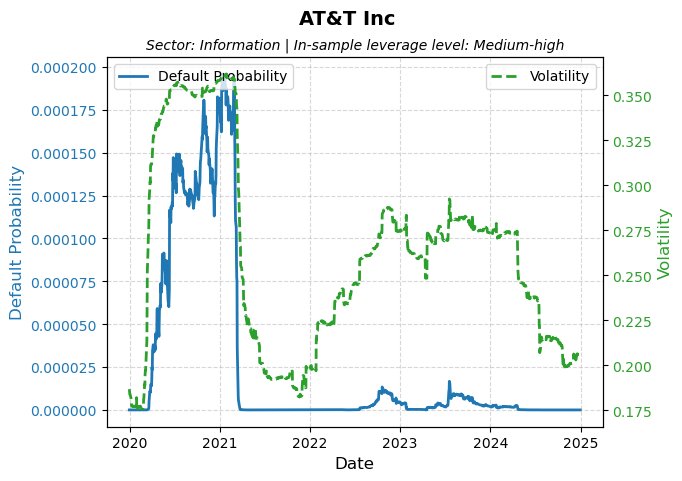

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

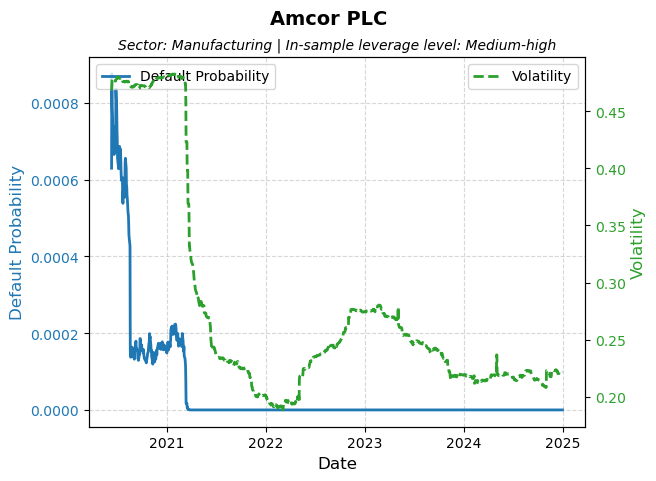

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

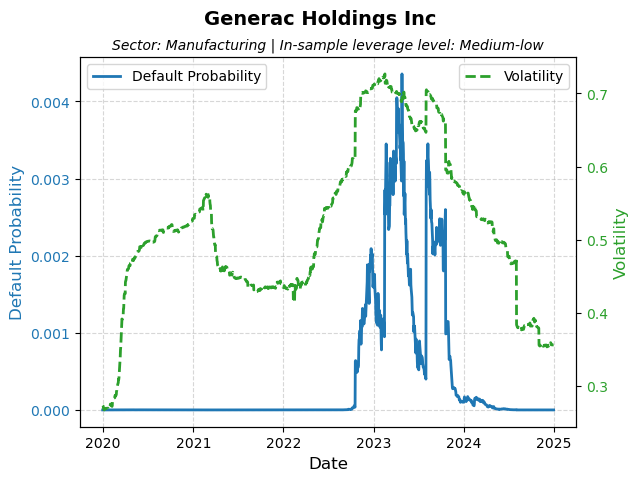

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

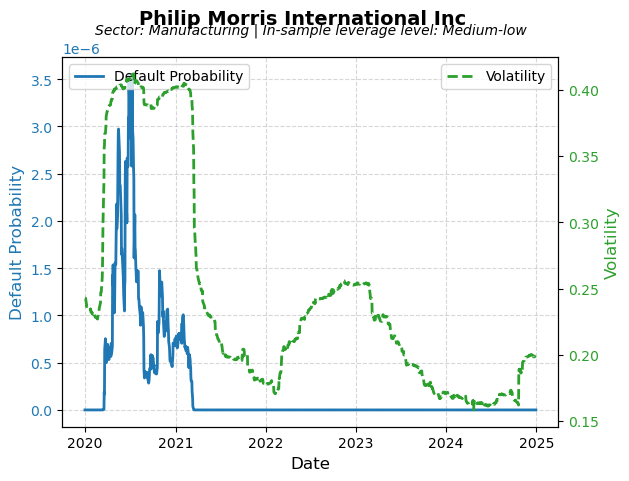

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

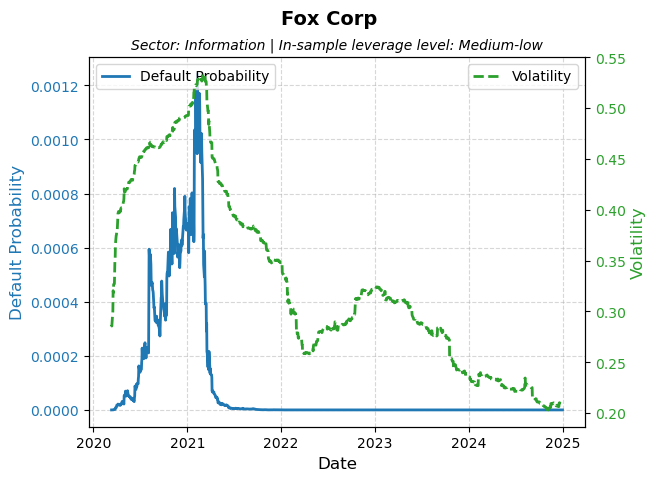

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

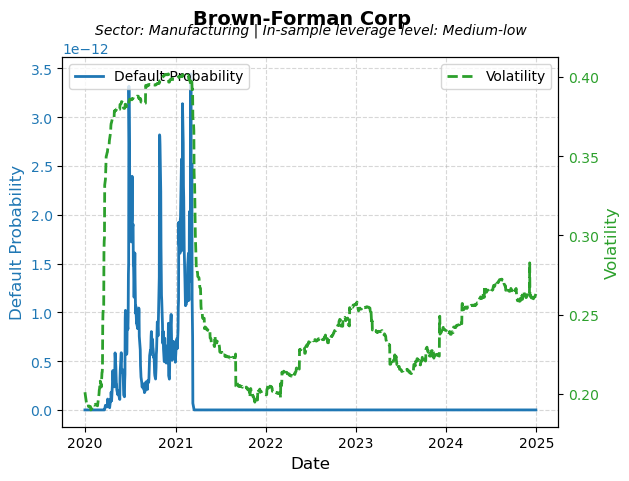

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

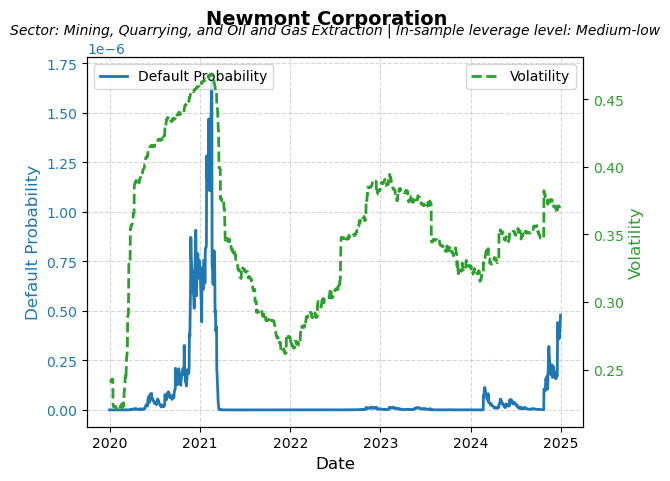

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

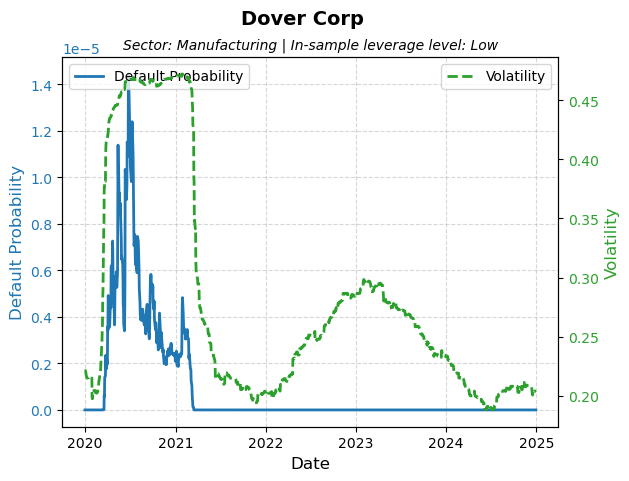

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

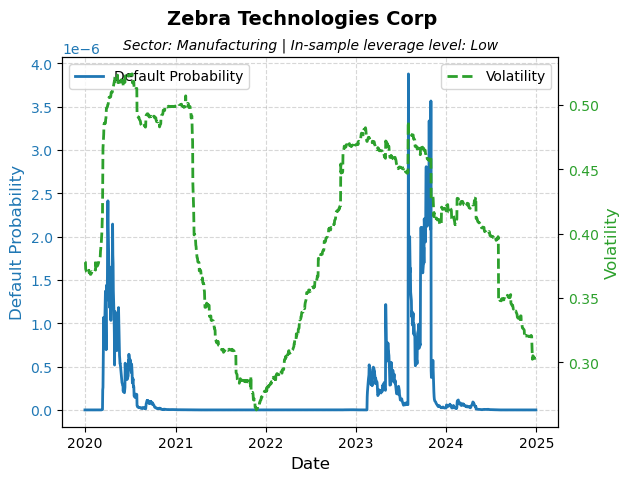

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

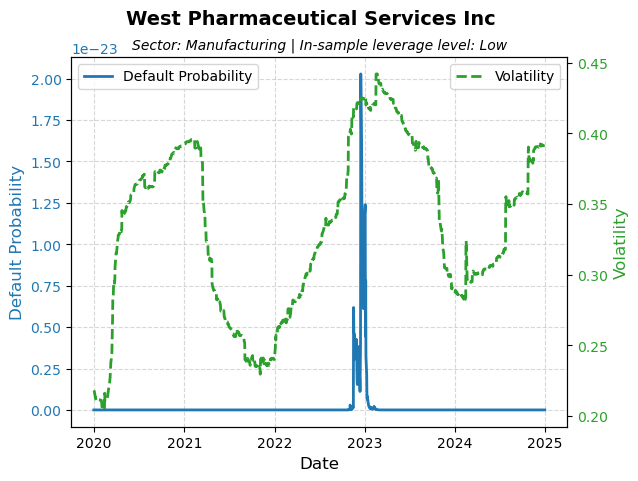

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

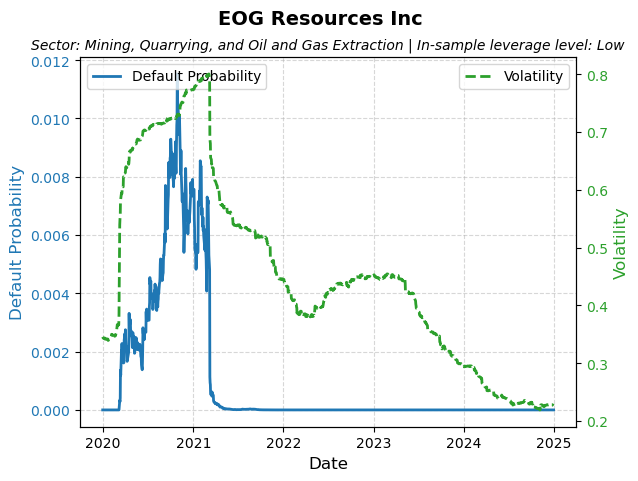

C:\Users\paolo\AppData\Local\Temp\ipykernel_2184\934727042.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot


<Figure size 2000x600 with 0 Axes>

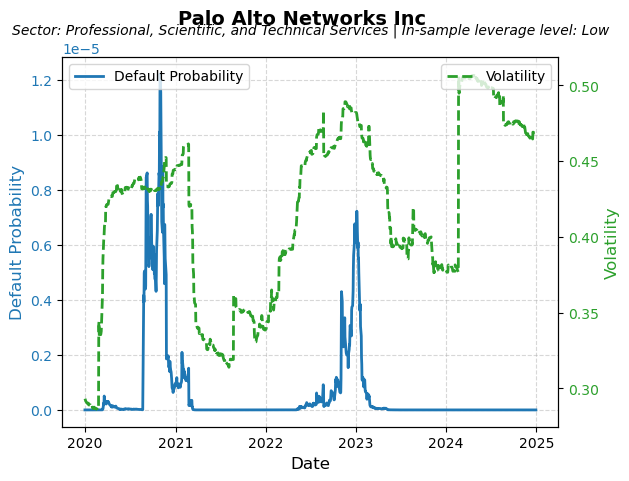

In [ ]:
for ric in rics_list:
    row_cross = data_cross[data_cross['Instrument'] == ric]

    sector = row_cross['NAICS Sector Name'].iloc[0]
    cluster = row_cross['ranked_clusters'].iloc[0]

    plt.figure(figsize=(20, 6))  # Adjust figure size for better visualization

    # Extract data
    def_probab = df_final.loc[ric]['Default_Probability']
    leverage_ratio = df_final.loc[ric]['Rolling_Volatility']

    # Create the main axis
    fig, ax1 = plt.subplots()

    # Plot Default Probability on the primary y-axis
    color1 = 'tab:blue'
    ax1.plot(def_probab, color=color1, label='Default Probability', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.plot(leverage_ratio, color=color2, label='Volatility', linewidth=2, linestyle='dashed')
    ax2.set_ylabel('Volatility', color=color2, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Add title and legend
    plt.suptitle(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')  # Move suptitle closer to the plot
    plt.title(f"Sector: {sector} | EOP 2024 In-sample leverage level: {cluster_dict[cluster]}", fontsize=10, fontstyle='italic')  # Move subtitle closer to suptitle

    fig.tight_layout(rect=[1, 1, 0.9, 0.88])  # Adjust layout to make more space for the plot
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()


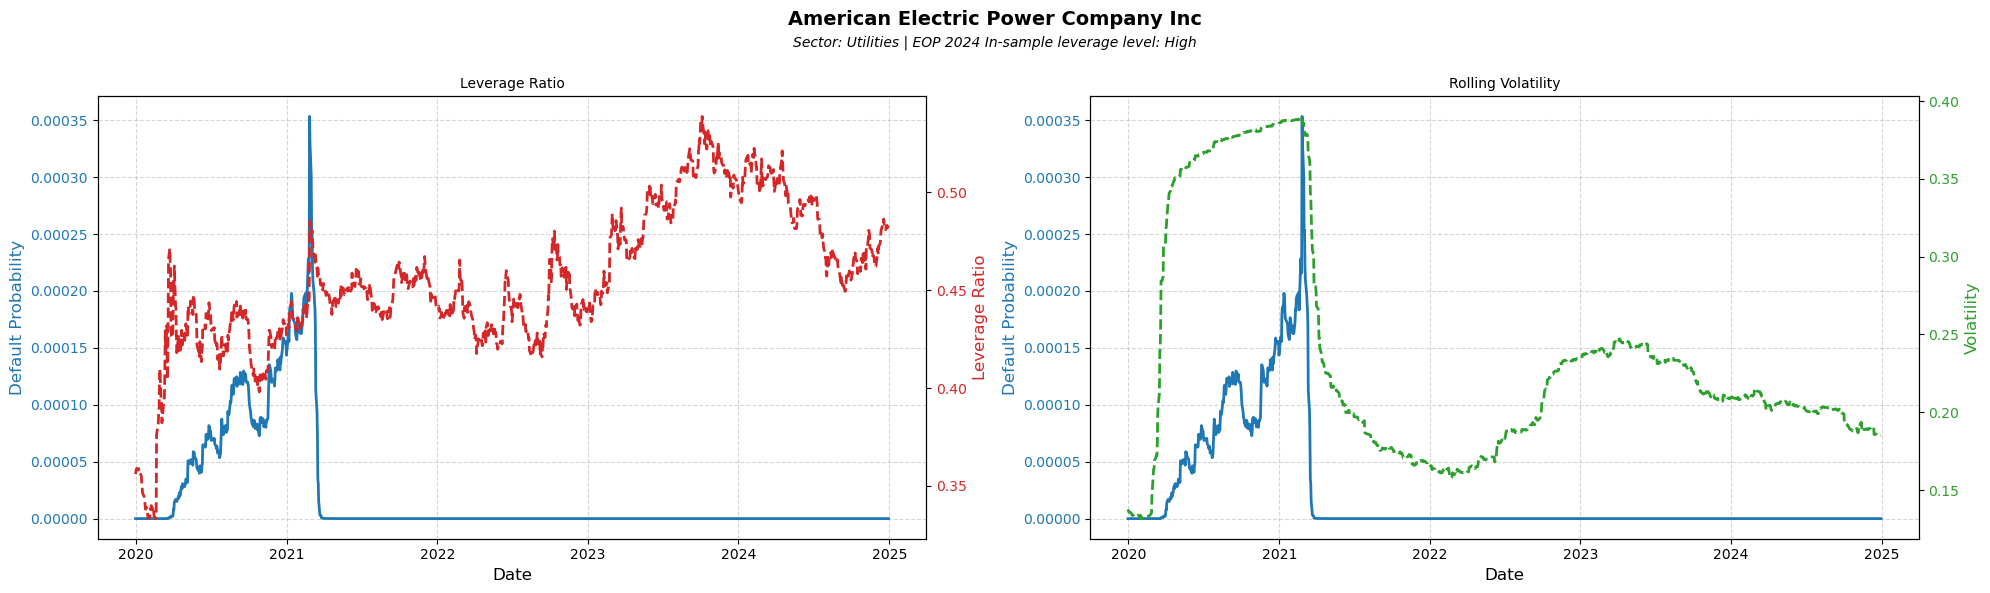

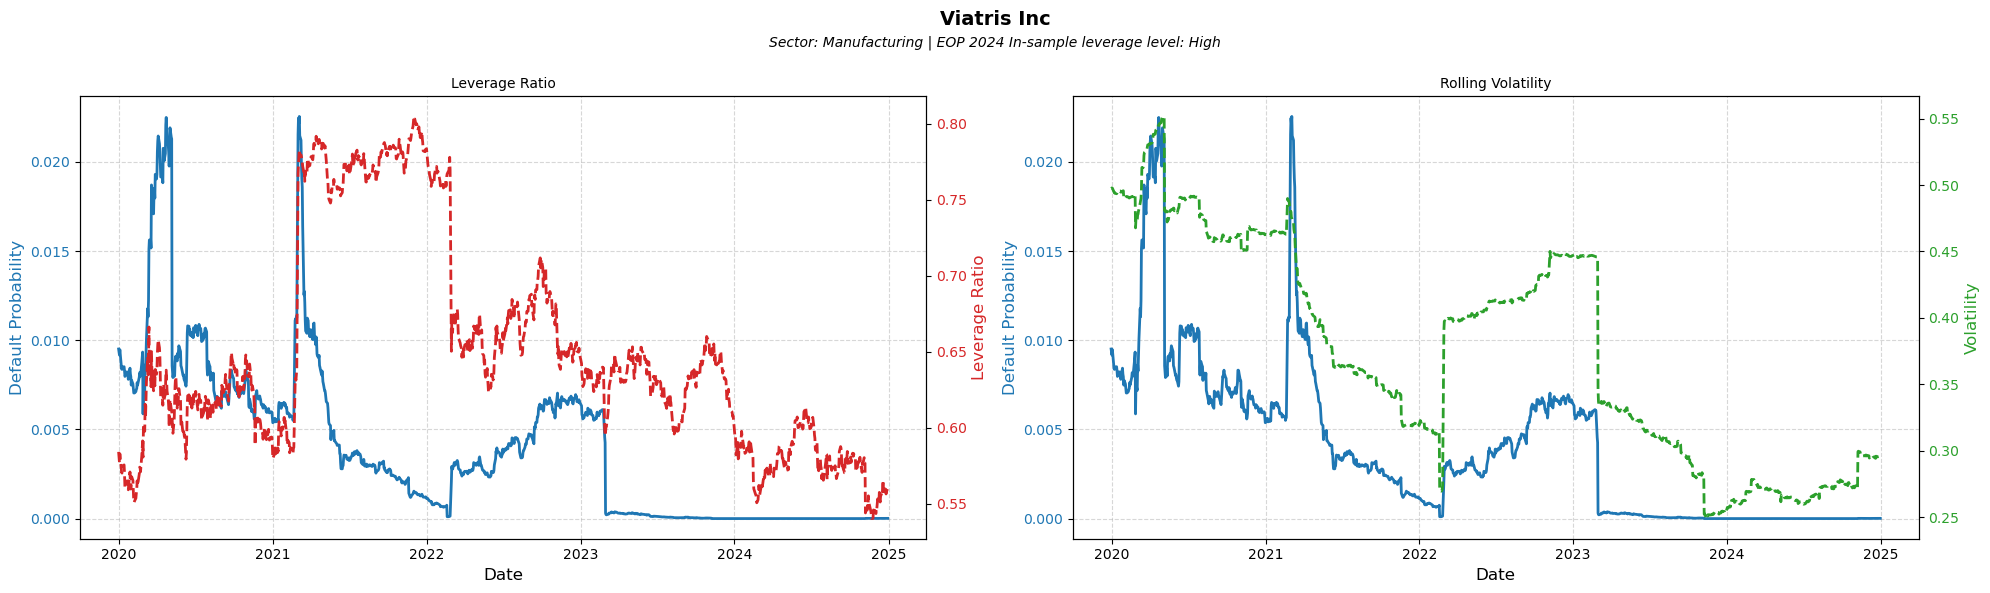

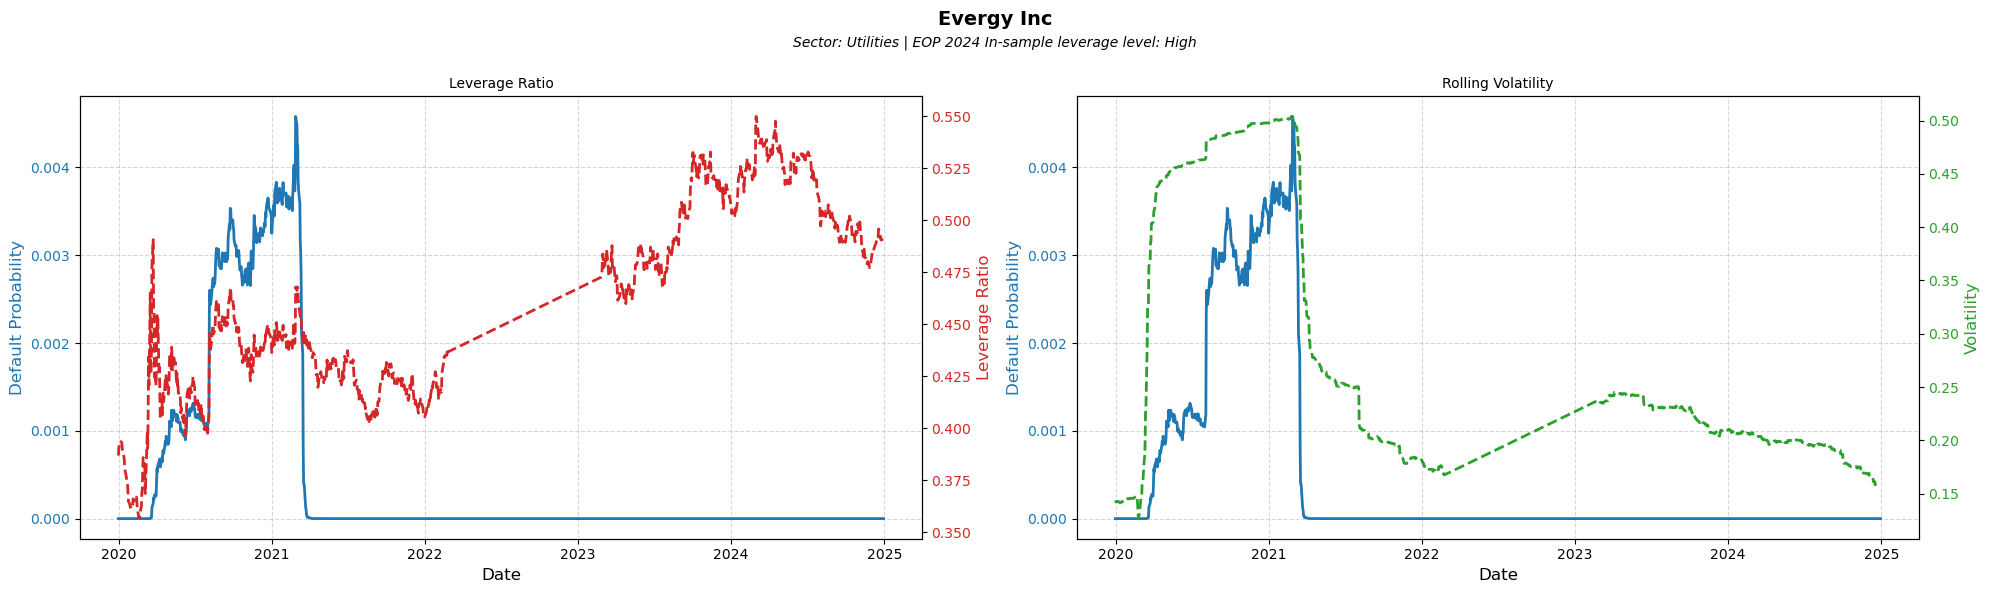

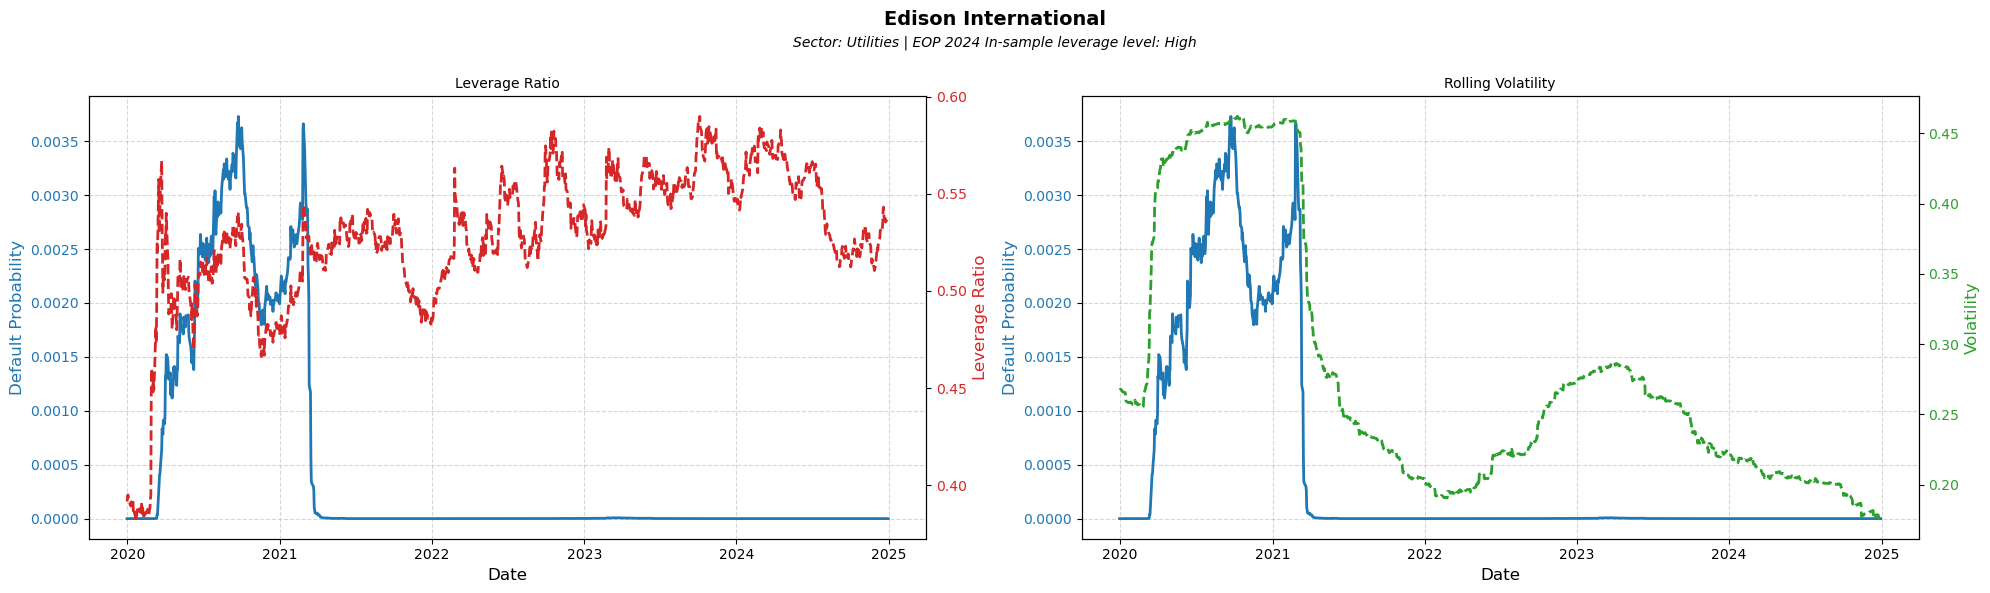

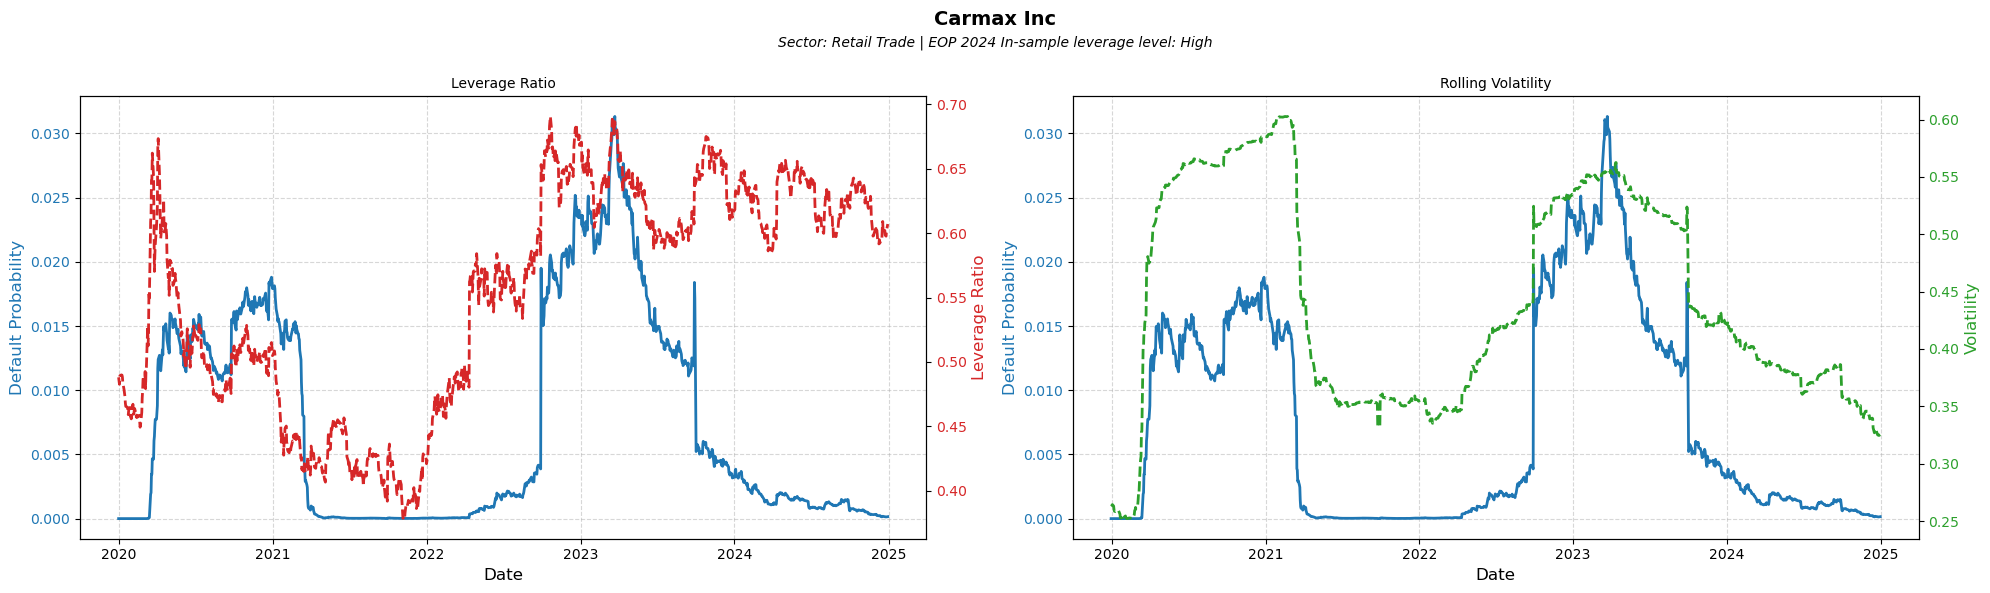

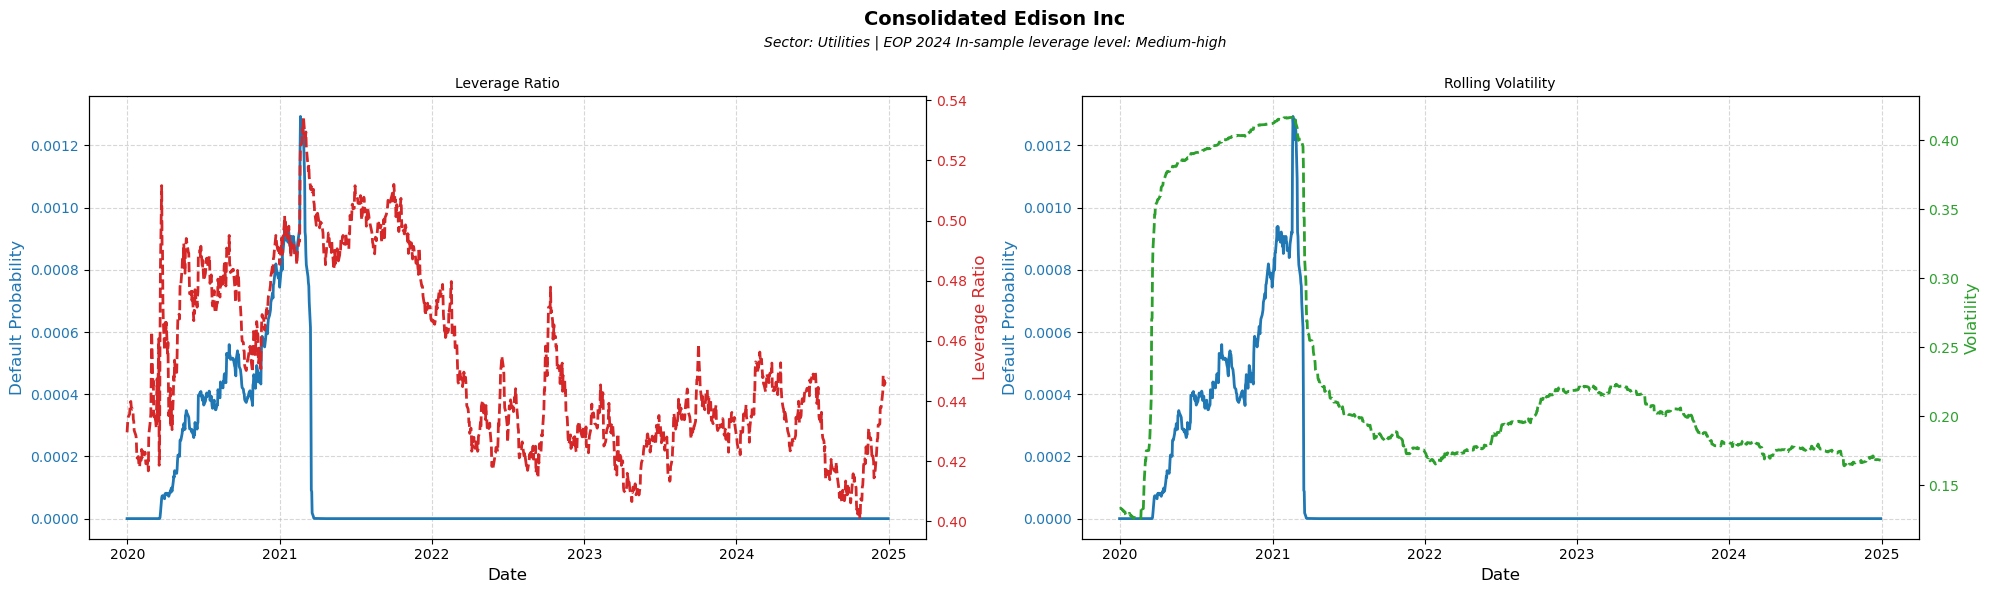

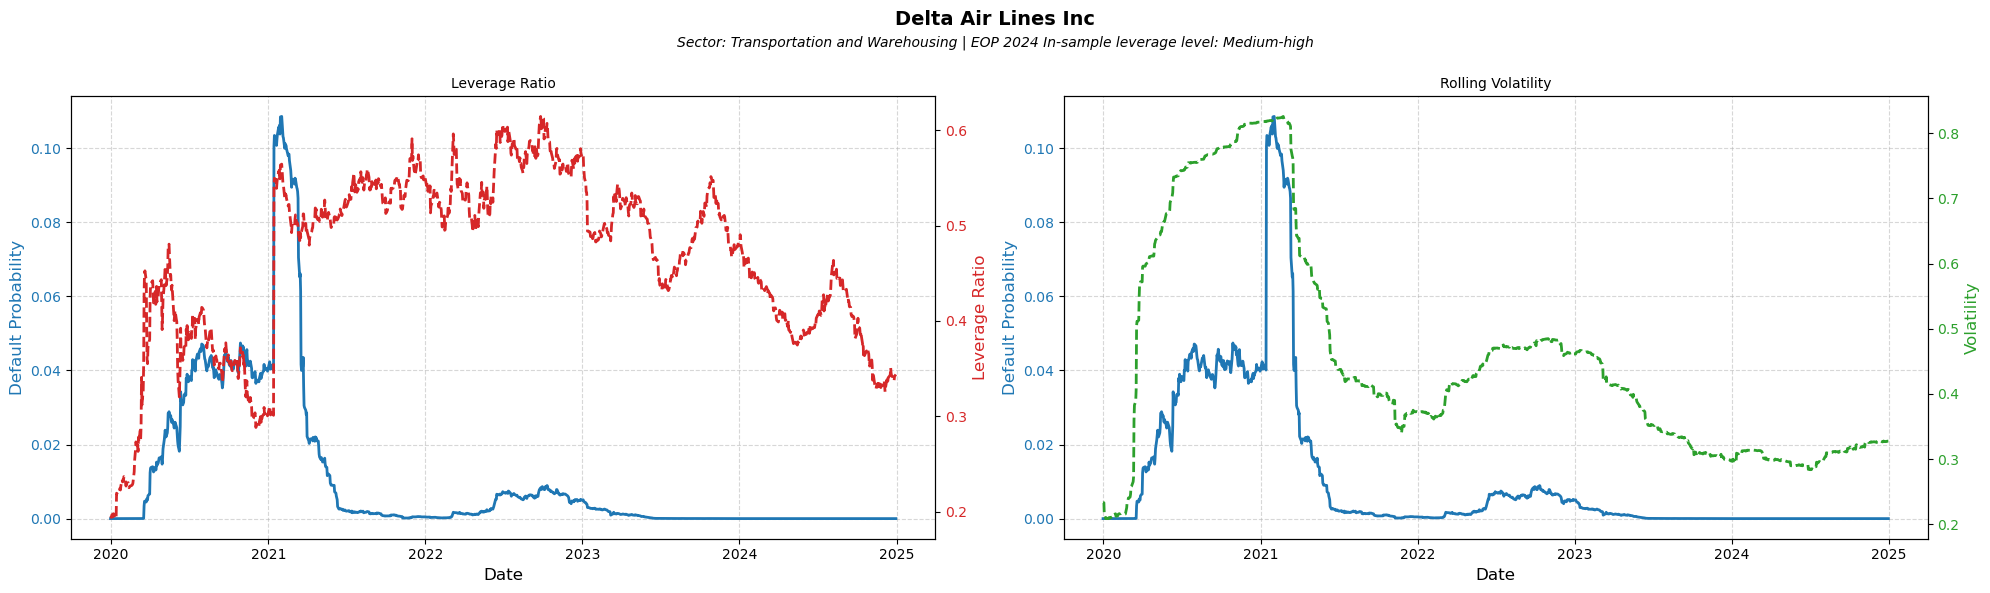

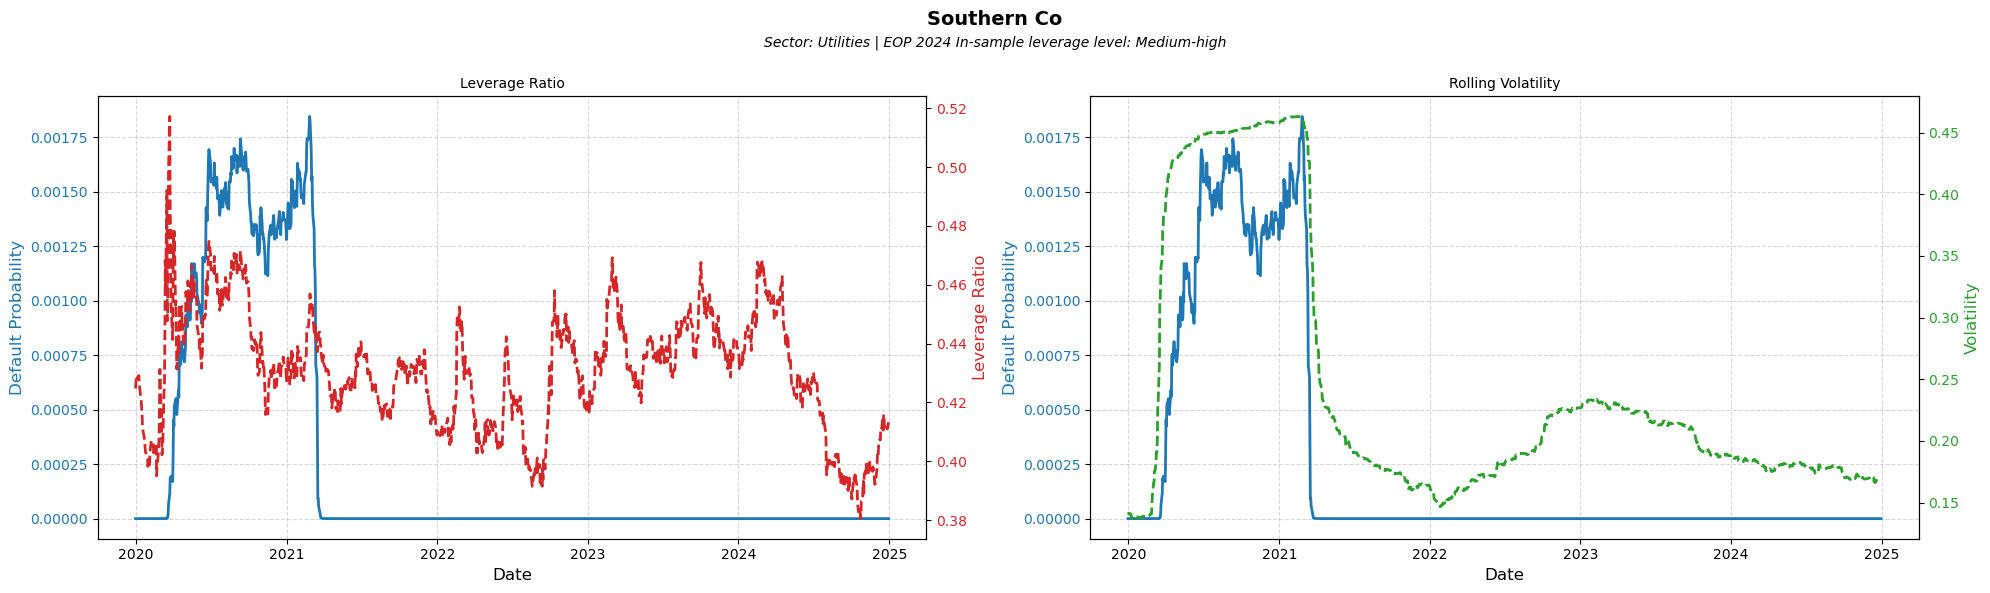

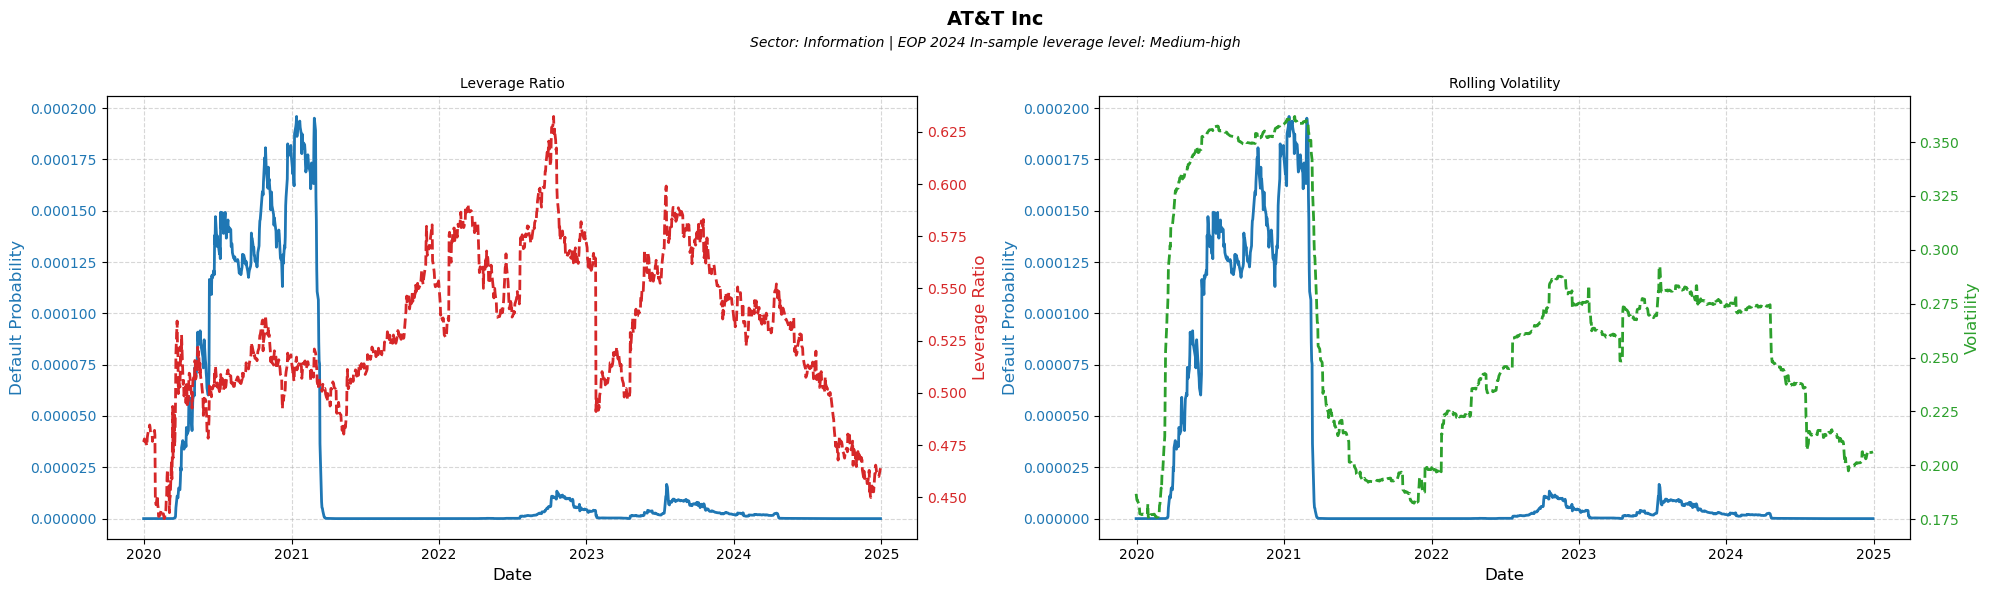

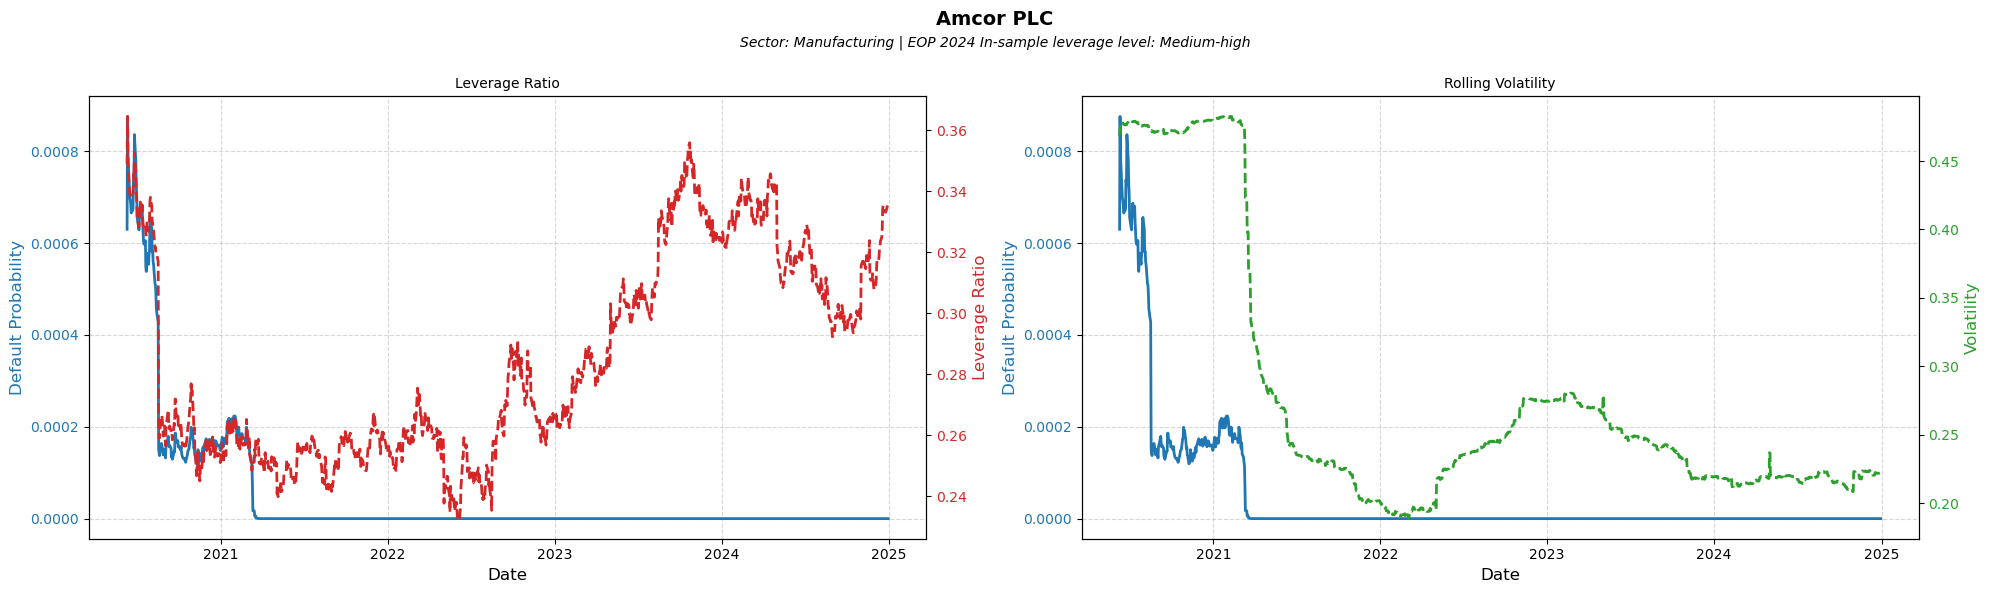

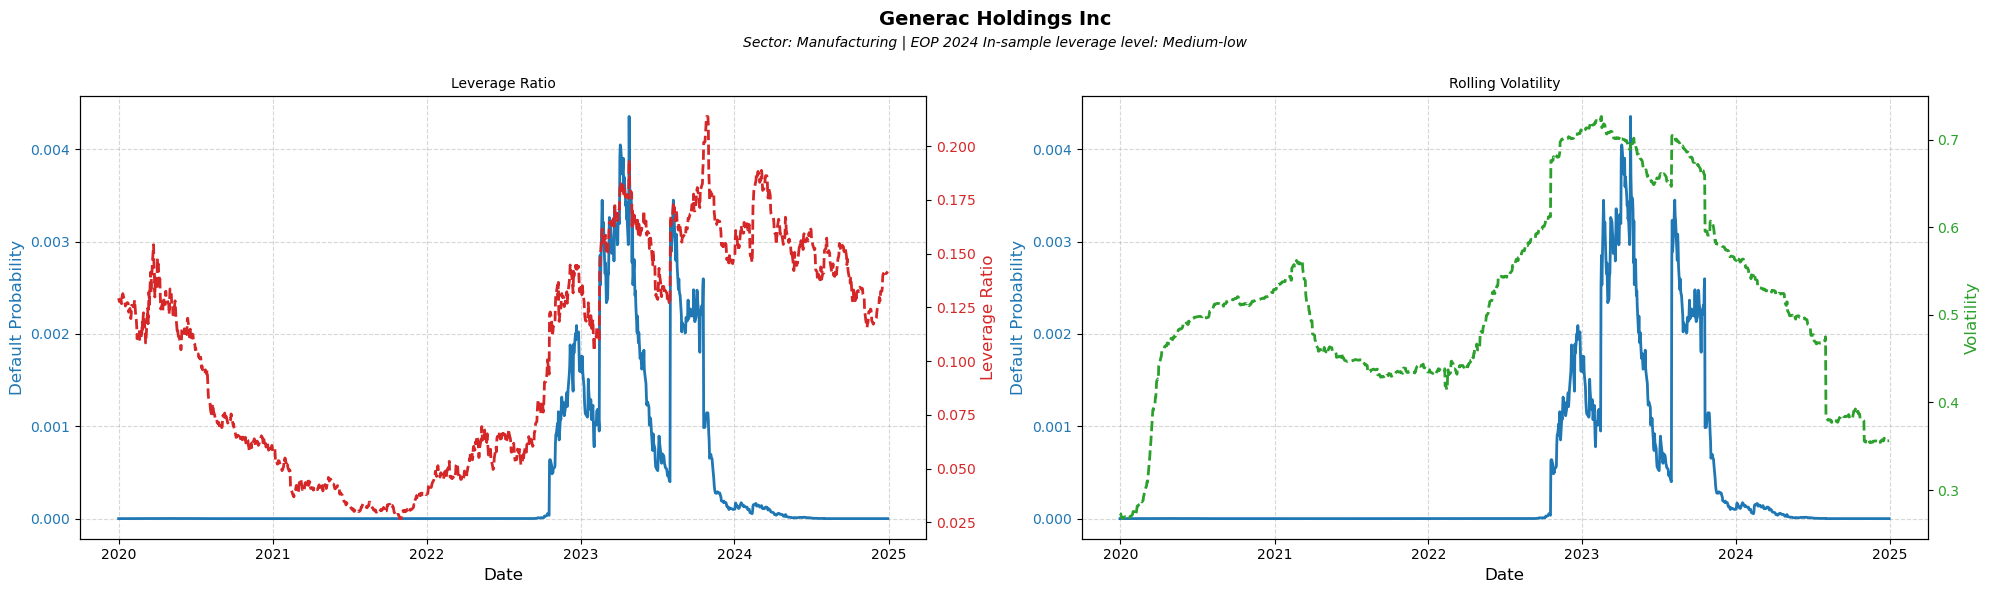

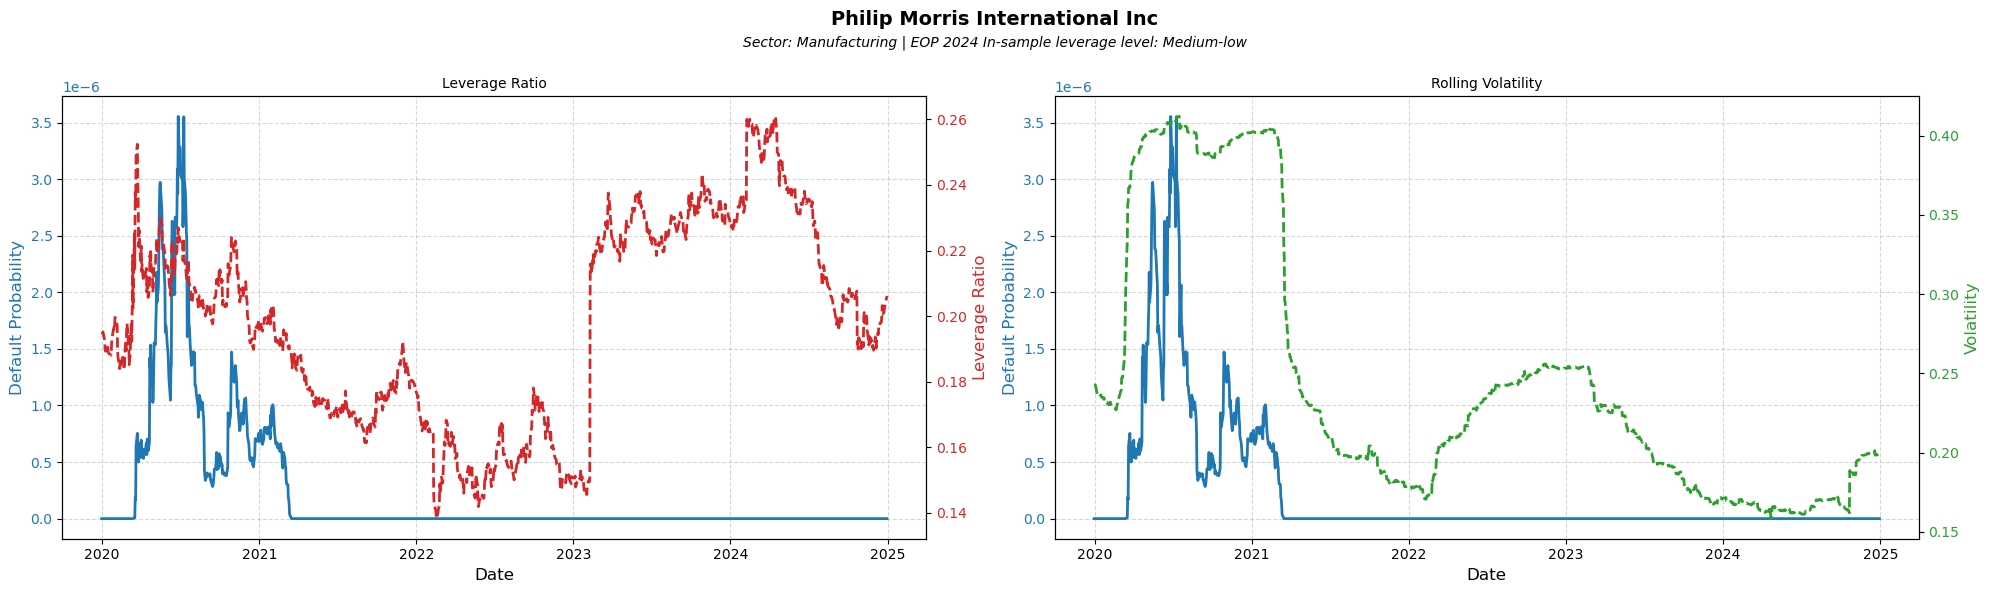

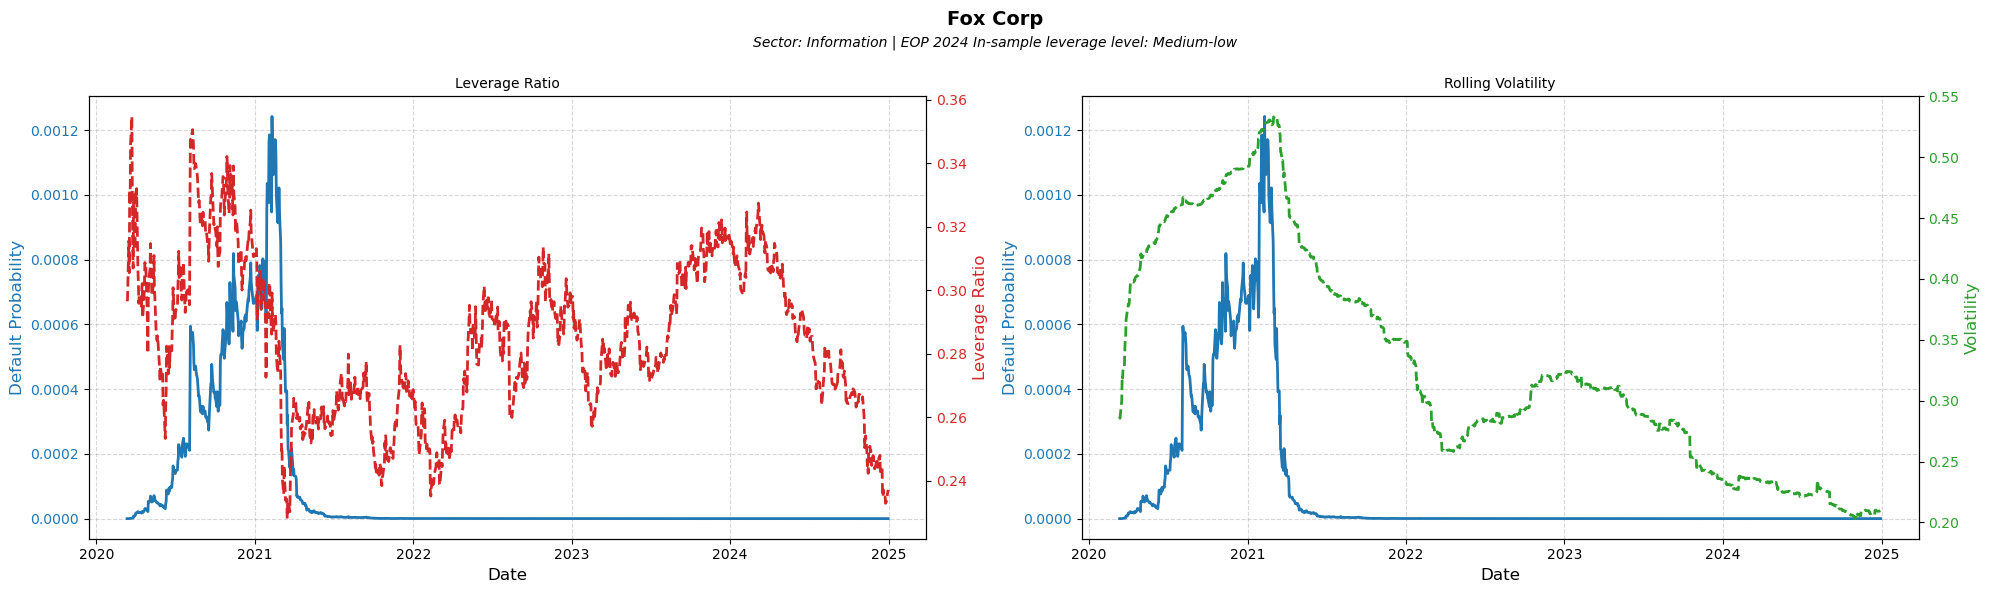

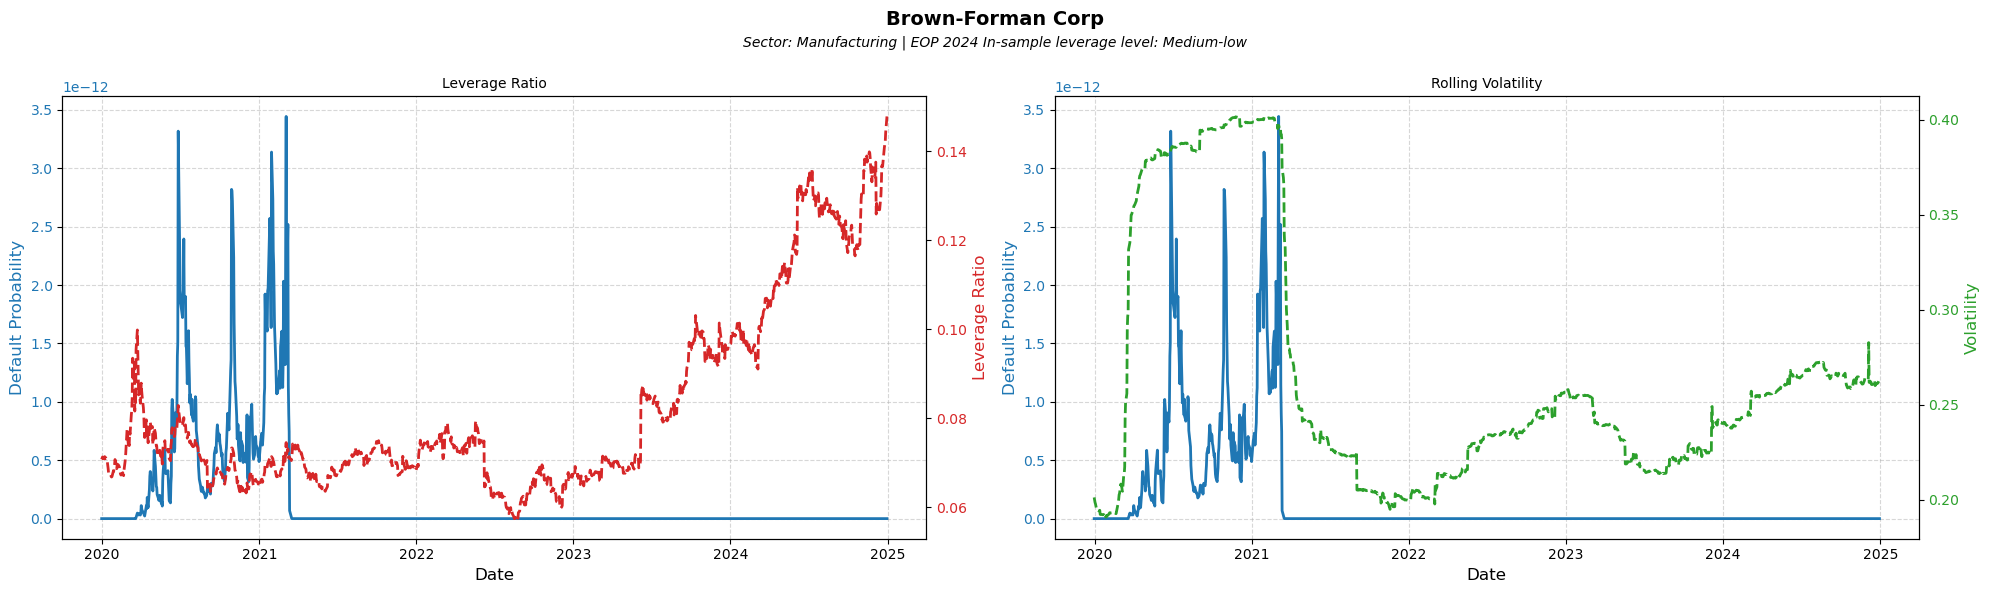

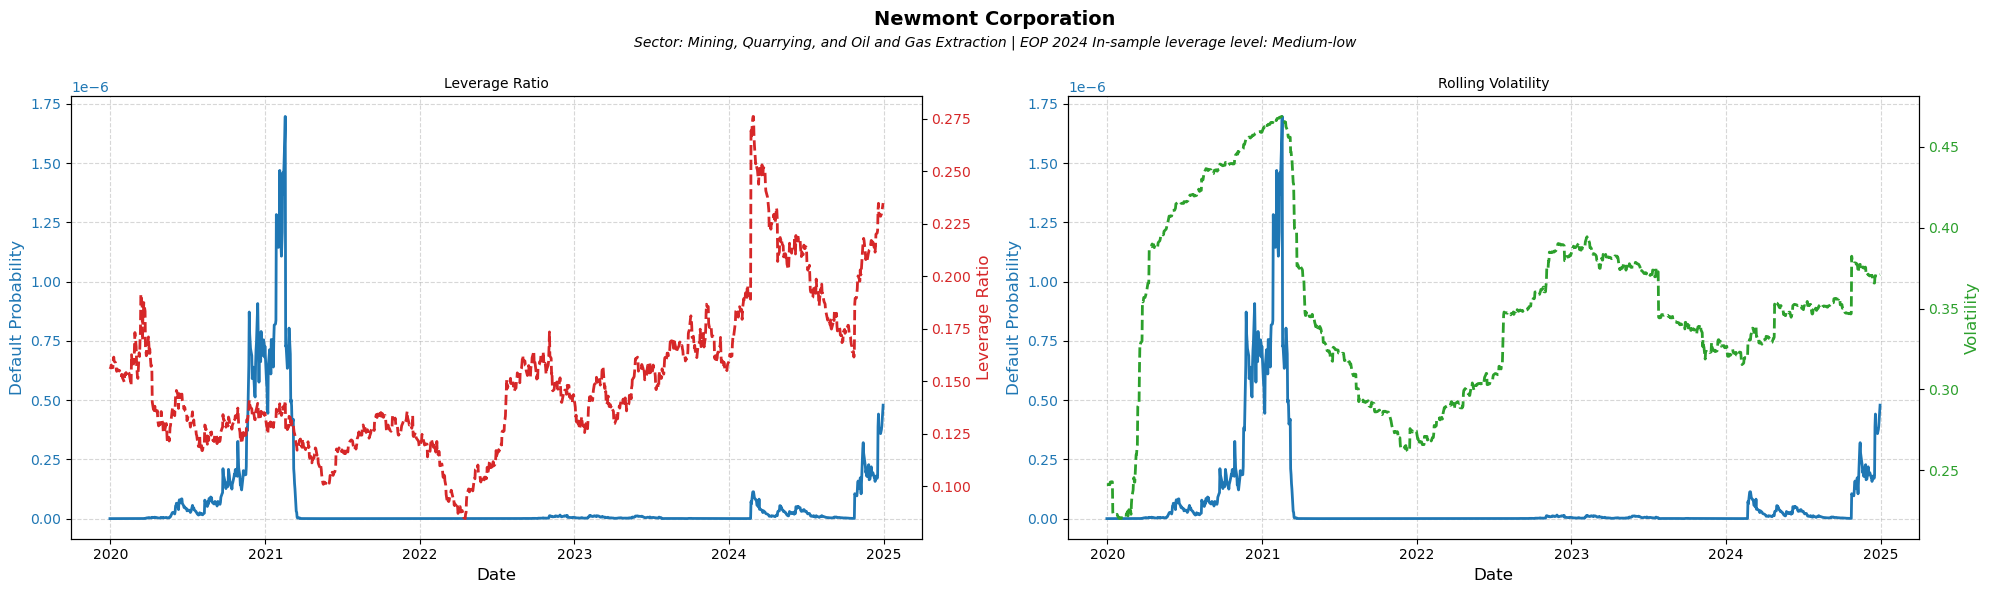

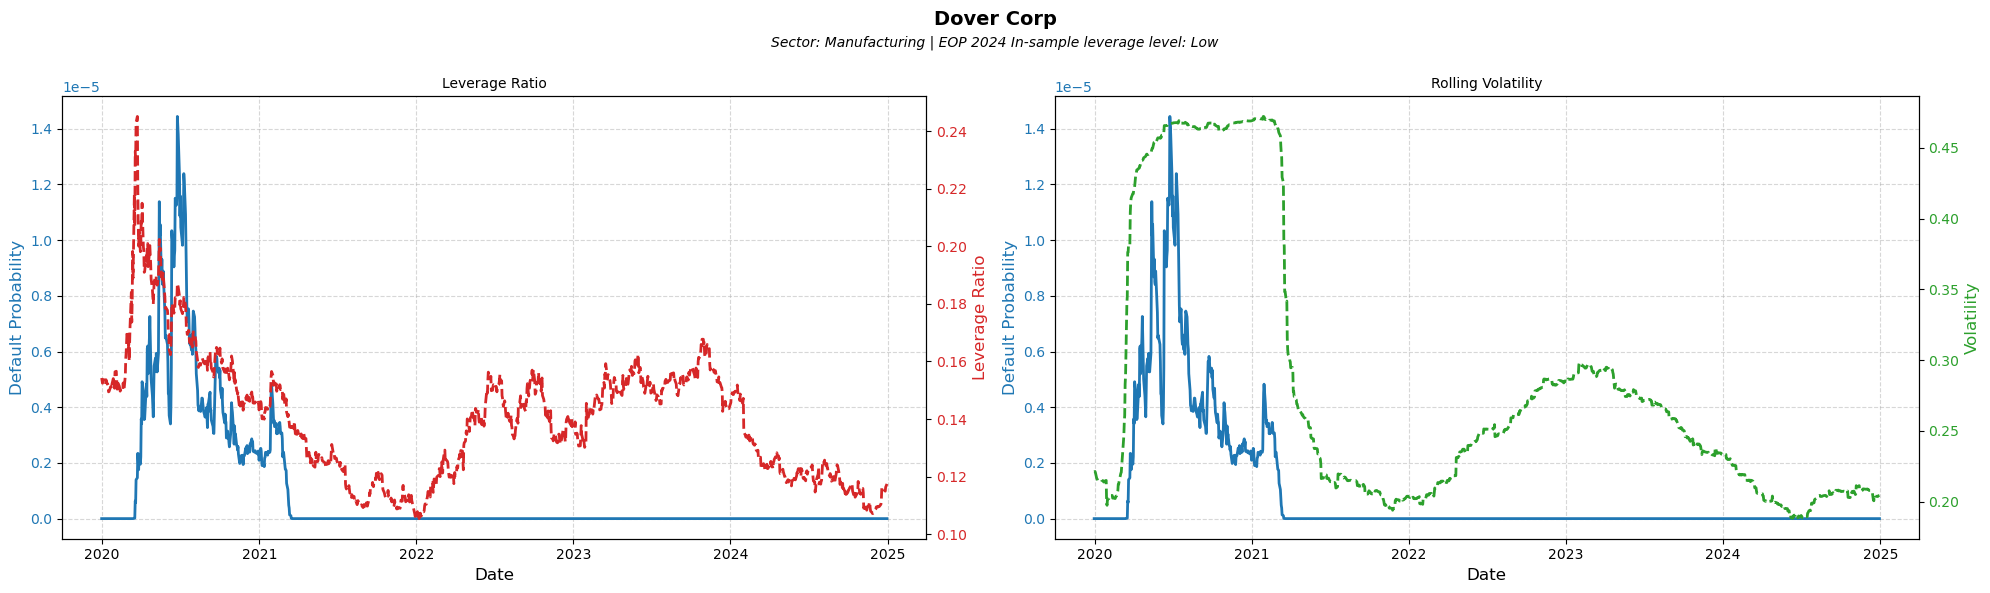

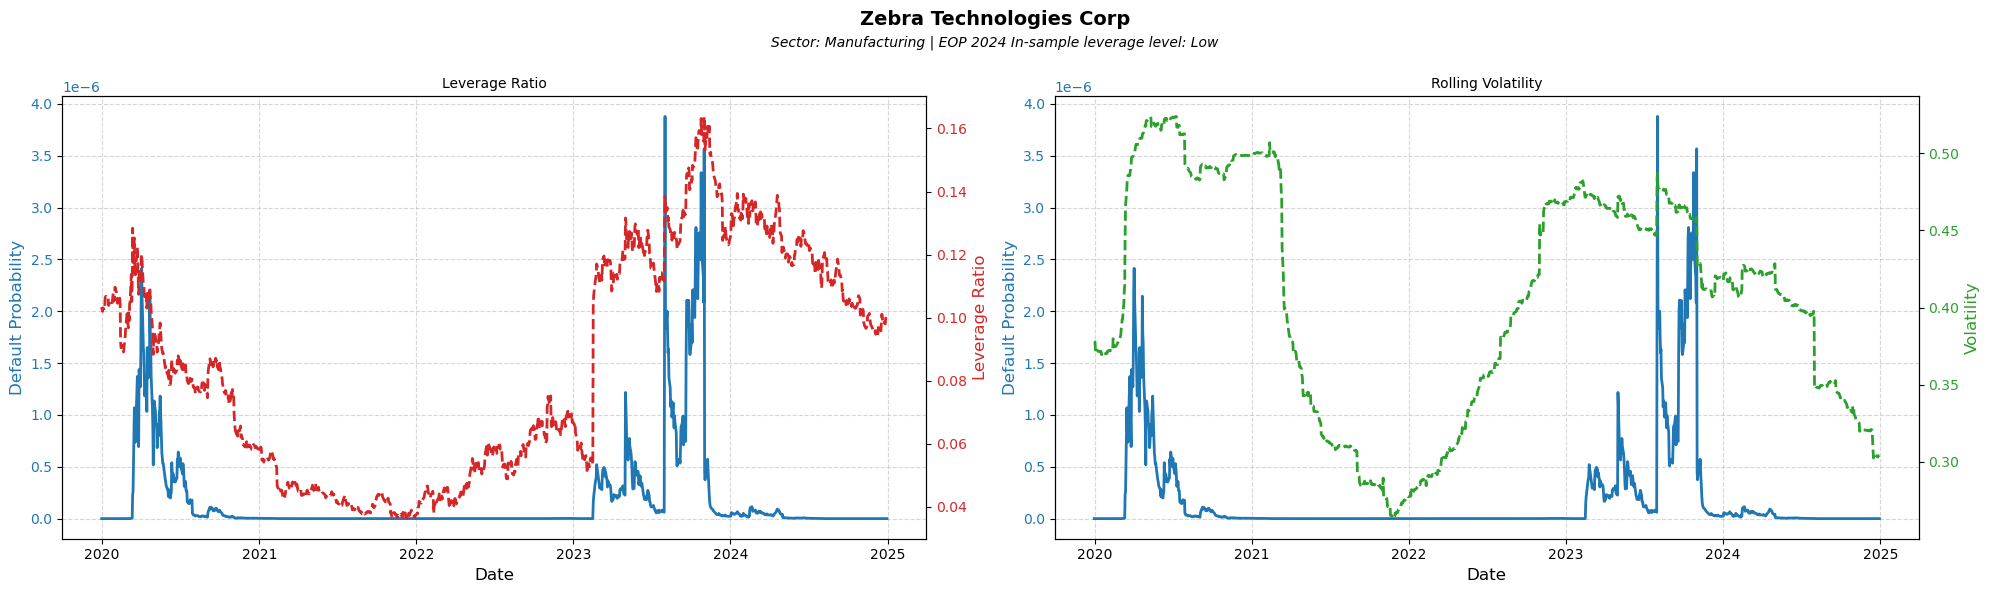

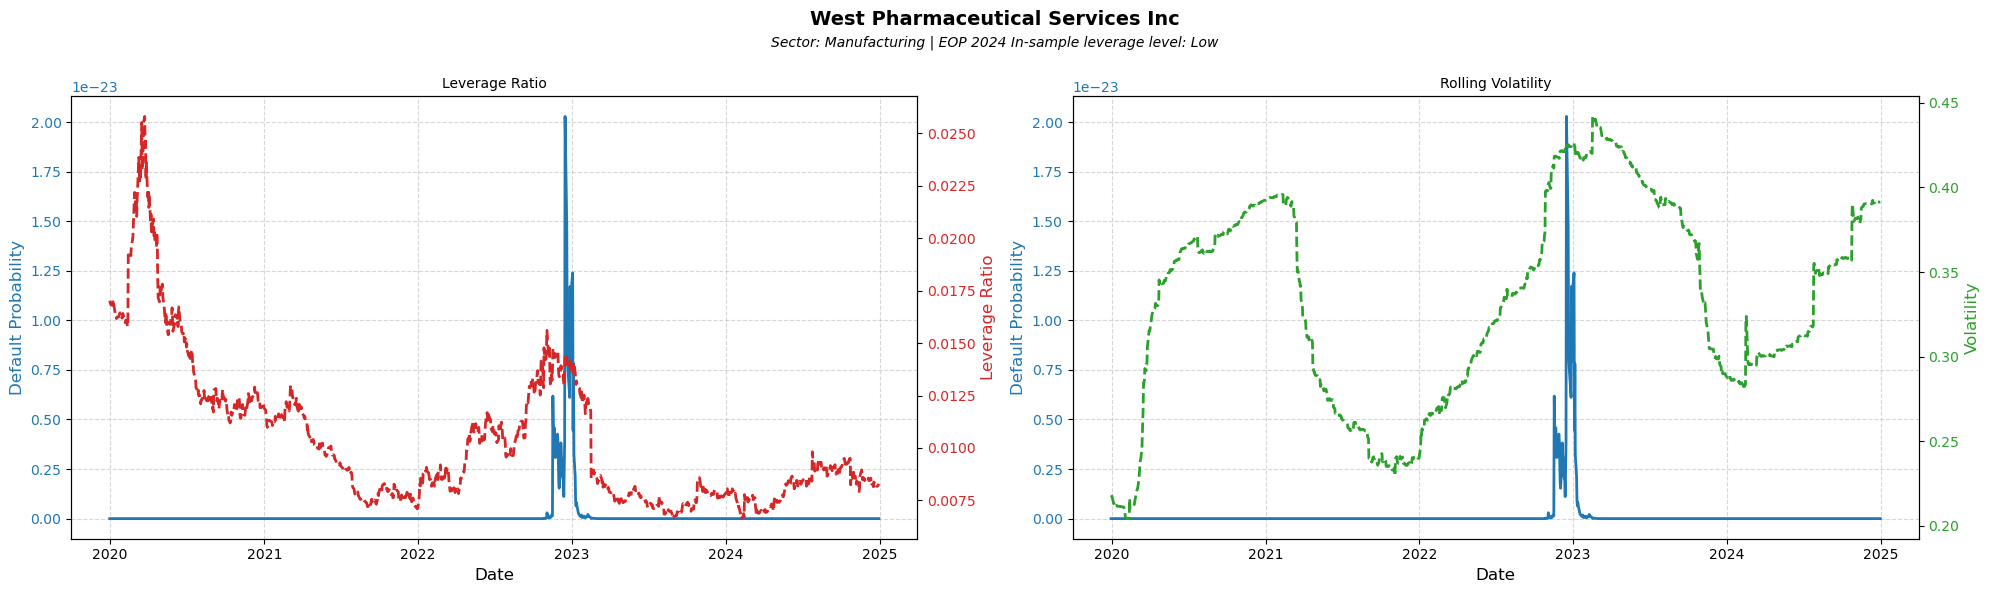

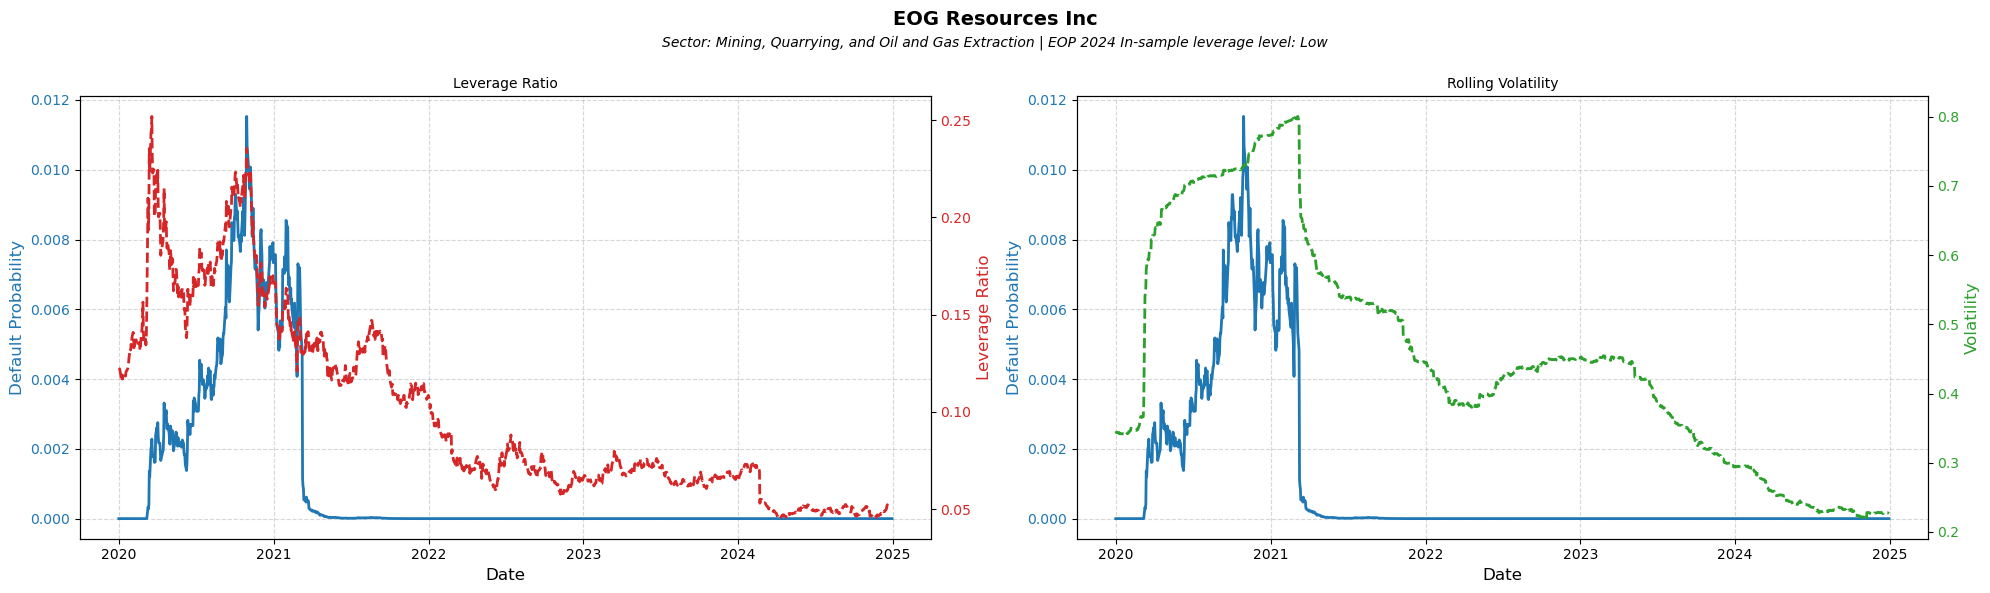

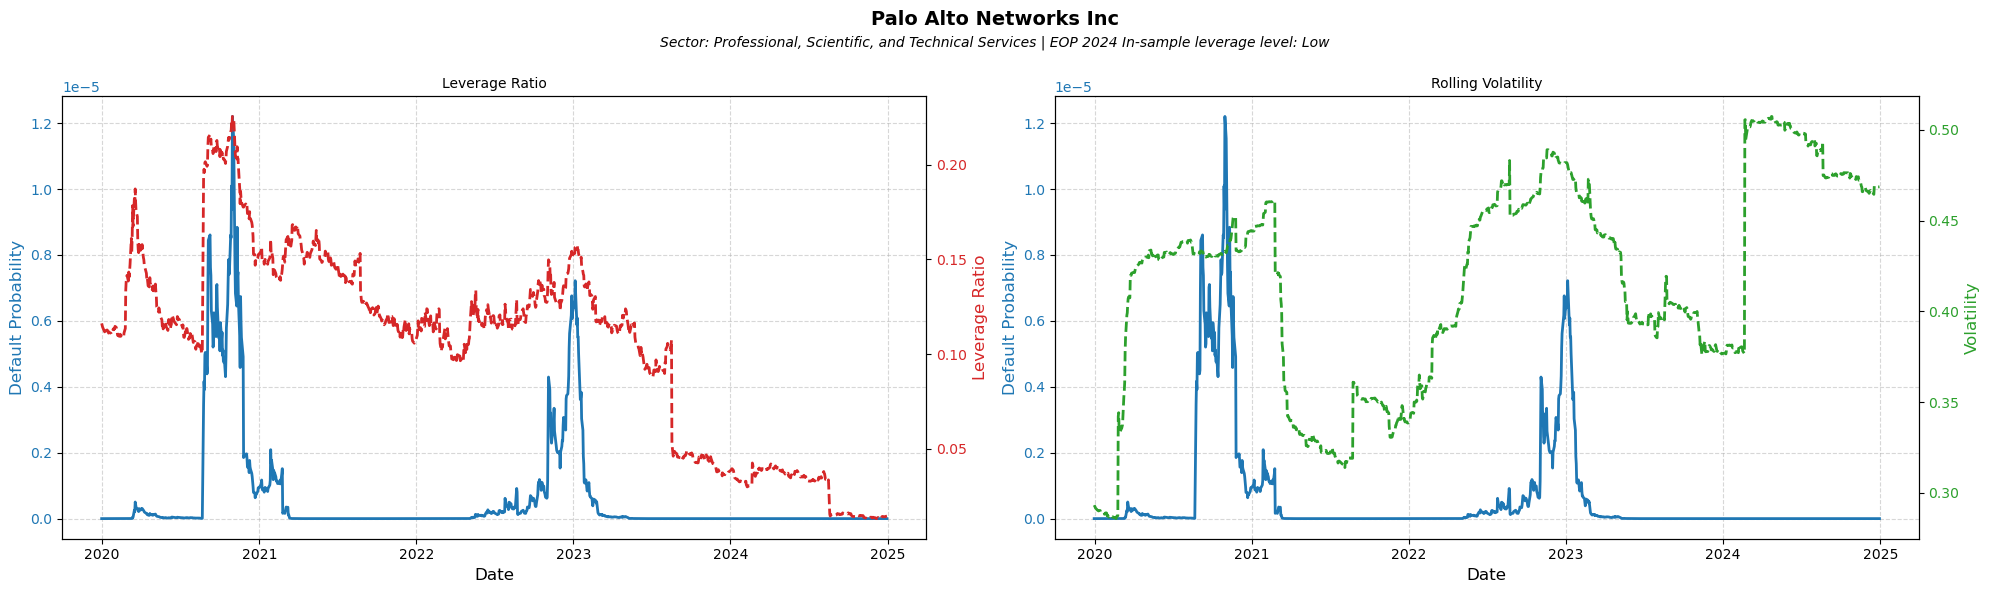

In [317]:
for ric in rics_list:
    row_cross = data_cross[data_cross['Instrument'] == ric]

    sector = row_cross['NAICS Sector Name'].iloc[0]
    cluster = row_cross['ranked_clusters'].iloc[0]

    # Extract data for the first plot
    def_probab_1 = df_final.loc[ric]['Default_Probability']
    leverage_ratio_1 = df_final.loc[ric]['Leverage_Ratio']

    # Extract data for the second plot
    def_probab_2 = df_final.loc[ric]['Default_Probability']
    leverage_ratio_2 = df_final.loc[ric]['Rolling_Volatility']

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

    # First plot (Default Probability vs Leverage Ratio)
    color1 = 'tab:blue'
    ax1.plot(def_probab_1, color=color1, label='Default Probability', linewidth=2)
    ax1.set_ylabel('Default Probability', color=color1, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the first plot
    ax1_twin = ax1.twinx()
    color2 = 'tab:red'
    ax1_twin.plot(leverage_ratio_1, color=color2, label='Leverage Ratio', linewidth=2, linestyle='dashed')
    ax1_twin.set_ylabel('Leverage Ratio', color=color2, fontsize=12)
    ax1_twin.tick_params(axis='y', labelcolor=color2)
    ax1.set_title(f"Leverage Ratio", fontsize=10)

    # Second plot (Default Probability vs Rolling Volatility)
    color3 = 'tab:blue'
    ax2.plot(def_probab_2, color=color3, label='Default Probability', linewidth=2)
    ax2.set_ylabel('Default Probability', color=color3, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Create a secondary y-axis for the second plot
    ax2_twin = ax2.twinx()
    color4 = 'tab:green'
    ax2_twin.plot(leverage_ratio_2, color=color4, label='Volatility', linewidth=2, linestyle='dashed')
    ax2_twin.set_ylabel('Volatility', color=color4, fontsize=12)
    ax2_twin.tick_params(axis='y', labelcolor=color4)
    ax2.set_title(f"Rolling Volatility", fontsize=10)

    # Adjust layout and overall title
    fig.suptitle(f'{rics_dict[ric]}', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.92, f"Sector: {sector} | EOP 2024 In-sample leverage level: {cluster_dict[cluster]}", 
         fontsize=10, fontstyle='italic', ha='center')
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin for the suptitle

    # Show the combined plot
    plt.show()


##### Checking the results

In [226]:
df_final.loc[rics_list[2]].tail()

Close Price  \
Date                                     
2024-12-23 00:00:00+00:00        61.32   
2024-12-24 00:00:00+00:00        61.75   
2024-12-26 00:00:00+00:00        61.68   
2024-12-27 00:00:00+00:00         61.7   
2024-12-30 00:00:00+00:00        61.52   

                           Shares used to calculate Diluted EPS - Total  \
Date                                                                      
2024-12-23 00:00:00+00:00                                   230500000.0   
2024-12-24 00:00:00+00:00                                   230500000.0   
2024-12-26 00:00:00+00:00                                   230500000.0   
2024-12-27 00:00:00+00:00                                   230500000.0   
2024-12-30 00:00:00+00:00                                   230500000.0   

                           Market Capitalization   Debt - Total      RIC  \
Date                                                                       
2024-12-23 00:00:00+00:00     11990452438.799999  13201800000.0  EVRG.OQ   
2024-12-24 00:00:00+00:00     11990452438.799999  13201800000.0  EVRG.OQ   
2024-12-26 00:00:00+00:00     11990452438.799999  13201800000.0  EVRG.OQ   
2024-12-27 00:00:00+00:00     11990452438.799999  13201800000.0  EVRG.OQ   
2024-12-30 00:00:00+00:00     11990452438.799999  13201800000.0  EVRG.OQ   

                            Equity_Value  Log_Returns  Rolling_Volatility  \
Date                                                                        
2024-12-23 00:00:00+00:00  14134260000.0    -0.001792            0.158886   
2024-12-24 00:00:00+00:00  14233375000.0     0.006988            0.158921   
2024-12-26 00:00:00+00:00  14217240000.0    -0.001134            0.158766   
2024-12-27 00:00:00+00:00  14221850000.0     0.000324            0.158766   
2024-12-30 00:00:00+00:00  14180360000.0    -0.002922            0.158659   

                             Total_value    A_solution  sigma_A_solution  \
Date                                                                       
2024-12-23 00:00:00+00:00  27336060000.0  2.681841e+10          0.083739   
2024-12-24 00:00:00+00:00  27435175000.0  2.691753e+10          0.084033   
2024-12-26 00:00:00+00:00  27419040000.0  2.690139e+10          0.083907   
2024-12-27 00:00:00+00:00  27423650000.0  2.690600e+10          0.083919   
2024-12-30 00:00:00+00:00  27382160000.0  2.686451e+10          0.083748   

                           Leverage_Ratio  Merton_Equity_Value  \
Date                                                             
2024-12-23 00:00:00+00:00        0.492266         1.374797e+10   
2024-12-24 00:00:00+00:00        0.490454         1.384709e+10   
2024-12-26 00:00:00+00:00        0.490748         1.383095e+10   
2024-12-27 00:00:00+00:00        0.490664         1.383556e+10   
2024-12-30 00:00:00+00:00        0.491422         1.379407e+10   

                           Merton_Debt_Value  Default_Probability  \
Date                                                                
2024-12-23 00:00:00+00:00       1.307044e+10         1.853897e-17   
2024-12-24 00:00:00+00:00       1.307044e+10         1.644078e-17   
2024-12-26 00:00:00+00:00       1.307044e+10         1.565594e-17   
2024-12-27 00:00:00+00:00       1.307044e+10         1.555544e-17   
2024-12-30 00:00:00+00:00       1.307044e+10         1.568051e-17   

                           Credit_Spread  
Date                                      
2024-12-23 00:00:00+00:00           -0.0  
2024-12-24 00:00:00+00:00           -0.0  
2024-12-26 00:00:00+00:00           -0.0  
2024-12-27 00:00:00+00:00           -0.0  
2024-12-30 00:00:00+00:00           -0.0

#### Debugging the credit spread

In [89]:
r = 0.01
T = 1
t = 0

sigma = 0.25


V = 3837473534.932722
#K = 931124000.0 * 2


p_0 = np.exp(-r * (T - t))
K = (V * 0.6) / p_0

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.6060301002505009
Log: 0.5108256237659907
Numerator: 0.5420756237659907
Volatility: 0.25
d1: 2.168302495063963
First addend: -0.027922564726853342
Second addend: 0.025113065607051538
Not discounted: 0.00242620838220305
Credit spread: 0.00242620838220305


In [90]:
#Test the credit spread model with mock examples
af.credit_spread_model(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

## Impact of Volatility on Credit Spread

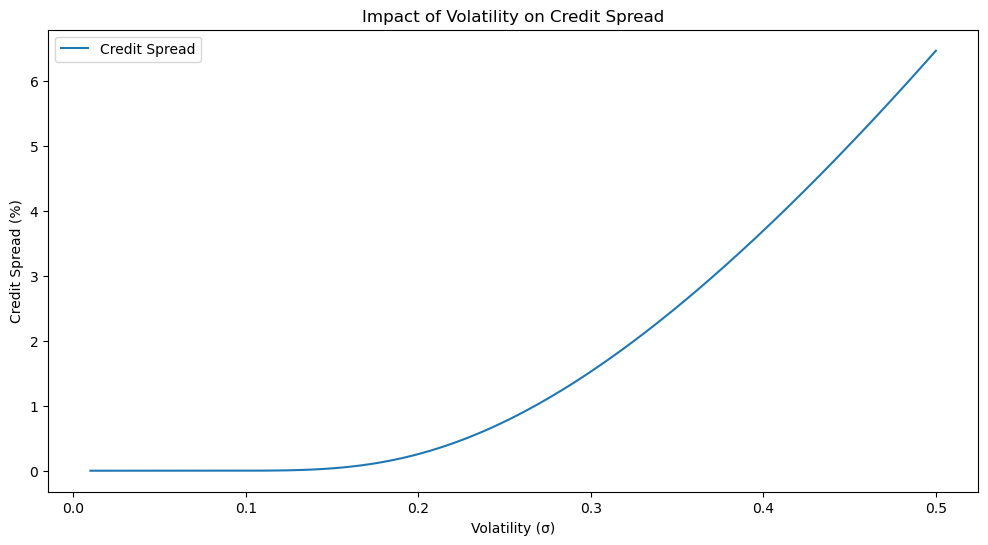

In [91]:
mp.plot_spread_vol(100,60,0,2,0)

## Impact of Time to Maturity on Credit Spread


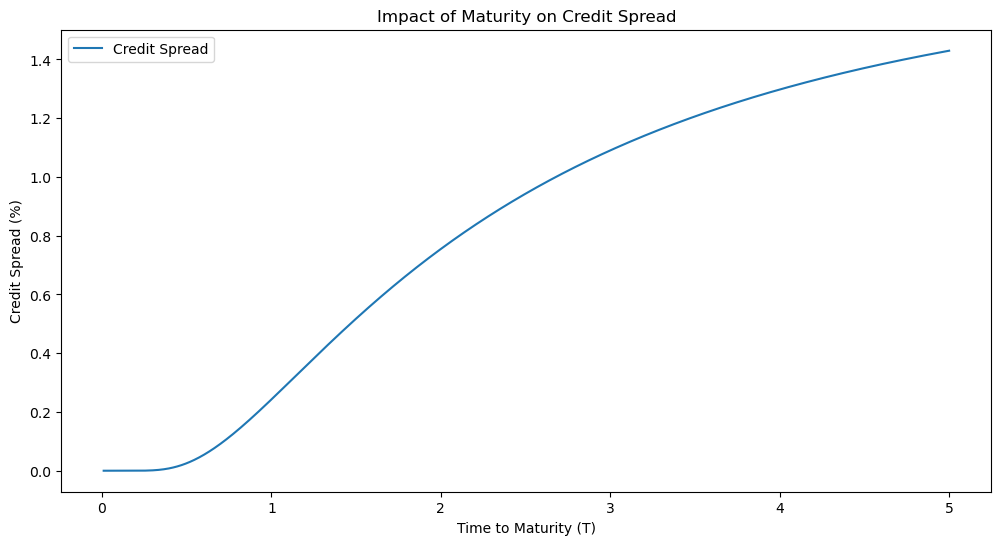

In [92]:
mp.plot_spread_time(100,60,0,2,0)

## Montecarlo simulations of the last observed day of each stock

We need a large number of simulations given the extremely low probabilities we obtain for highly capitalized firms 

In [93]:
data.loc[ric].iloc[-1,:]

Close Price                                            9.093
Shares used to calculate Diluted EPS - Total       323640100
Market Capitalization                           3706536975.0
Debt - Total                                     931124000.0
RIC                                                  BRBI.MI
Equity_Value                                    2942859429.3
Log_Returns                                        -0.003623
Rolling_Volatility                                  0.245485
Total_value                                     3873983429.3
Name: 2024-12-30 00:00:00+00:00, dtype: object

In [94]:
931124000.0 / 3837473535.041267

0.24263984923872237

In [95]:
rics_list 


['AAPL.O', 'META.O', 'BRBI.MI']

In [96]:
importlib.reload(af)
import time as time
mc_probabilities = {}
rics_paths = {}

for ric in rics_list:

    row = df_with_solutions.loc[ric].iloc[-1]
    
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    M = 1_000_000

    print('-'*100)
    print(f'{ric}\n')
    print(row)
    print('\n')
    
    merton_prob = af.default_probability(V, K, r, sigma, T , t)
    
    
    print(f'\nThe probability of default according to the Merton model is: {merton_prob}\n')
    
    mc_prob = af.monte_carlo_merton(V, K, r, sigma, T, M)
    mc_prob_anti = af.monte_carlo_merton_anti(V, K, r, sigma, T, M)


----------------------------------------------------------------------------------------------------
AAPL.O

Close Price                                                    252.2
Shares used to calculate Diluted EPS - Total             15408095000
Market Capitalization                                3463350367230.0
Debt - Total                                          107525000000.0
RIC                                                           AAPL.O
Equity_Value                                         3885921559000.0
Log_Returns                                                -0.013352
Rolling_Volatility                                          0.225923
Total_value                                          3993446559000.0
A_solution                                      3989230443444.853516
sigma_A_solution                                            0.220073
Leverage_Ratio                                              0.026954
Risk_Free_Rate                                                 

In [97]:
"""
    mc_probabilities[ric] = mc_prob
    print(f'Merton probability is: {merton_prob}')
    print(f'Monte Carlo Merton is: {mc_prob}')

    st = time.time()

    steps = 1000
    batch_size = 10_000
    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)
    et = time.time()

    print(f'TIme elapsed = {et- st}')
    #rics_paths[ric] = paths
"""
    

"\n    mc_probabilities[ric] = mc_prob\n    print(f'Merton probability is: {merton_prob}')\n    print(f'Monte Carlo Merton is: {mc_prob}')\n\n    st = time.time()\n\n    steps = 1000\n    batch_size = 10_000\n    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)\n    et = time.time()\n\n    print(f'TIme elapsed = {et- st}')\n    #rics_paths[ric] = paths\n"

In [98]:
# plt.figure()

# ric = rics_list[-1]
# M = 10000
# mc_prob_2, paths = af.monte_carlo_path(V, K, r, sigma, T, M, steps)
# rics_paths[ric] = paths


# paths_sing = rics_paths[ric]

# if mc_prob_2 > 0:

#     plt.axhline(np.log(V))

#     for i in range(paths_sing.shape[0]):

#         plt.plot(paths_sing[i, :], alpha = 0.2)

#     plt.axhline(np.log(K))
#     plt.title(f'A {M} simulations for {ric}')

#     plt.show()

## Ratings of S&P 500

In [99]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


c:\Users\paolo\anaconda3\envs\grad\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [100]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             30
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
BBB-             9
WR               9
A-               7
F1               6
A+               6
WD               6
Ba2              6
Discontinued     5
BB+              4
BB               4
F2               4
Aa2              4
P-3              3
Ba3              2
BB-              2
B-               2
B1               2
F3               2
AA-              2
B                2
LGD2 - 20%       1
Aaa              1
LGD4 - 68%       1
(P)Baa3          1
B+               1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
AA               1
(P)Baa2          1
LGD4 - 54%       1
Name: count, dtype: Int64

In [101]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

Instrument        Company Common Name Issuer Rating
63       DAY.N               Dayforce Inc            B1
346     CZR.OQ  Caesars Entertainment Inc            B1